In [47]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import glob
import pickle
import platform
import copy

import proplot as pplt
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from vendi_score import vendi
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap

from graph_utils import *
from data_utils import *
from model_utils import *
from analysis_utils import *
from saliency_utils import *
from generation_utils import *

DATA_DIR = "/scratch/gpfs/sj0161/topo_data/"
WEIGHT_DIR = "/scratch/gpfs/sj0161/topo_result/"
ANALYSIS_DIR = "/scratch/gpfs/sj0161/topo_analysis/"
PLOT_DIR = "/scratch/gpfs/sj0161/topo_figure/"



pplt.rc["figure.facecolor"] = "white"

COLORS = []
colors = pplt.Cycle("538")
for color in colors:
    COLORS.append(color["color"])
colors = pplt.Cycle("default")
for color in colors:
    COLORS.append(color["color"])

LATENT_DIM = 8
DT = 0.001
NAMES = ["linear","cyclic", "branch", "comb", "star", "dendrimer"]


(x_train, y_train, c_train, l_train, graph_train), \
(x_valid, y_valid, c_valid, l_valid, graph_valid), \
(x_test, y_test, c_test, l_test, graph_test), \
_, SCALER, LE = load_data(os.path.join(DATA_DIR, "rg2.pickle"), fold=0, if_validation=True)

# Accuracy Metrics Bar Plot

In [13]:
with open(os.path.join(WEIGHT_DIR, "accuracy_metric.pickle"), "rb") as handle:
    baccs = pickle.load(handle)
    rmses = pickle.load(handle)
    r2s = pickle.load(handle)
    f1s = pickle.load(handle)
    kls = pickle.load(handle)

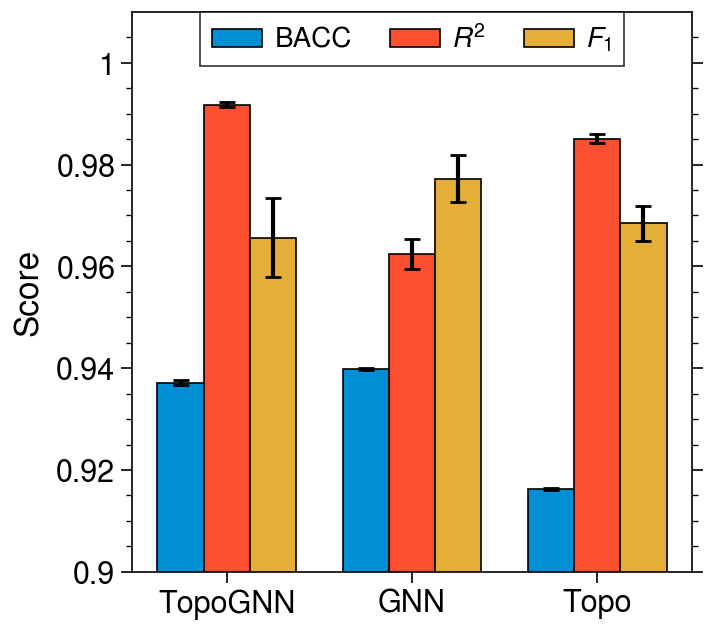

In [14]:
fig, ax = pplt.subplots(refwidth=2.8, refheight=2.8)
ax.bar(np.arange(3)-0.25, baccs[..., 2].mean(axis=1), yerr=baccs[..., 2].std(axis=1), color=COLORS[0], edgecolor="k", width=.25, label="BACC")
ax.bar(np.arange(3), r2s[..., 2].mean(axis=1), yerr=r2s[..., 2].std(axis=1), color=COLORS[1], edgecolor="k", width=.25, label=r"$\mathit{R}^2$")
ax.bar(np.arange(3)+0.25, f1s[..., 2].mean(axis=1), yerr=f1s[..., 2].std(axis=1), color=COLORS[2], edgecolor="k", width=.25, label=r"$\mathit{F}_1$")

ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

legend = ax.legend(loc="upper center")

for text in legend.get_texts():
    text.set_fontsize(10)

ax.format(xticks=[0,1,2], xticklabels=["TopoGNN", "GNN", "Topo"], 
          ylim=(0.9, 1.01), ylabel="Score", yticks=[0.9, 0.92, 0.94, 0.96, 0.98, 1.0],
          xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")

ax.set_xticks([], minor=True)
ax.yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")


fig.savefig(os.path.join(PLOT_DIR, "accuracy_metric.png"), dpi=300, bbox_inches="tight")

# Rg² Regression Parity Plots

In [19]:
with open(os.path.join(ANALYSIS_DIR, "all_outs.pickle"), "rb") as handle:
    train_outs = pickle.load(handle)
    valid_outs = pickle.load(handle)
    test_outs = pickle.load(handle)

### Parity Plot TopoGNN

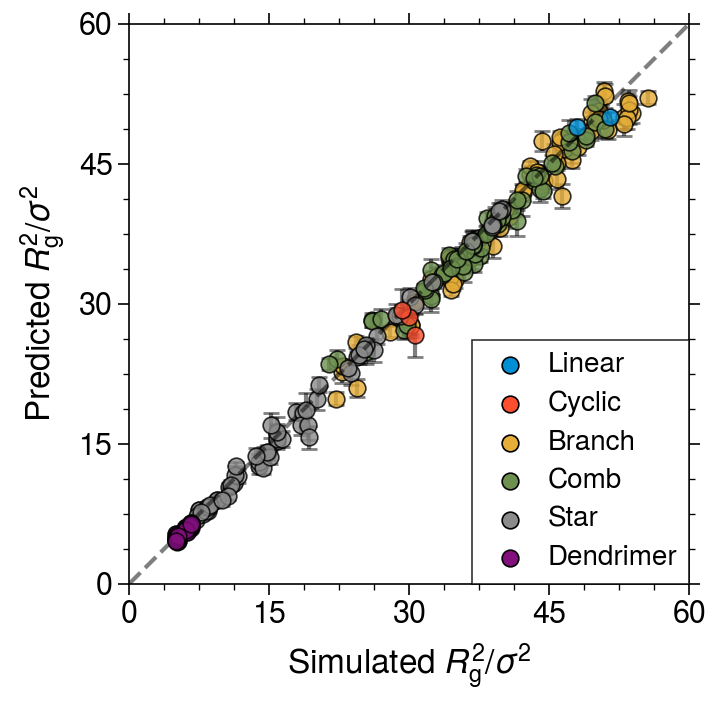

In [20]:
fig, ax = pplt.subplots(refwidth=2.8, refheight=2.8)

c_o_test = LE.inverse_transform(c_test)

for i in range(6):
    idx = np.where(c_o_test == NAMES[i])[0]
    if NAMES[i] == "linear" or NAMES[i] == "cyclic" or NAMES[i] == "dendrimer":
        zorder = 3 
    else:
        zorder = 1
    ax.scatter(y_test[idx], np.array(test_outs[0][1]).mean(axis=0)[idx,0], 
               c=COLORS[i], alpha=0.8, label=NAMES[i].capitalize(), edgecolor="k", zorder=zorder)
    ax.errorbar(y_test[idx], np.array(test_outs[0][1]).mean(axis=0)[idx,0],
                np.array(test_outs[0][1]).std(axis=0)[idx,0], fmt="none",
               c="k", alpha=0.5, zorder=0)

ax.plot([0, 60], [0, 60], "k--", alpha=0.5)

legend = ax.legend(ncols=1, loc="lower right")

for text in legend.get_texts():
    text.set_fontsize(10)

for handle in legend.legendHandles:
    handle.set_alpha(1)

ax.format(ylabel=r"Predicted $\mathit{R}_g^2/\mathit{\sigma}^2$", xlabel=r"Simulated $\mathit{R}_g^2/\mathit{\sigma}^2$",
          xlim=[0, 60], ylim=[0, 60],
          xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")

ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

ax.xaxis.set_tick_params(labelbottom=True, labeltop=False, top=True, bottom=True, which="both")
ax.yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")

fig.savefig(os.path.join(PLOT_DIR, "accuracy_parity.png"), dpi=300, bbox_inches="tight")

### Parity Plot GNN

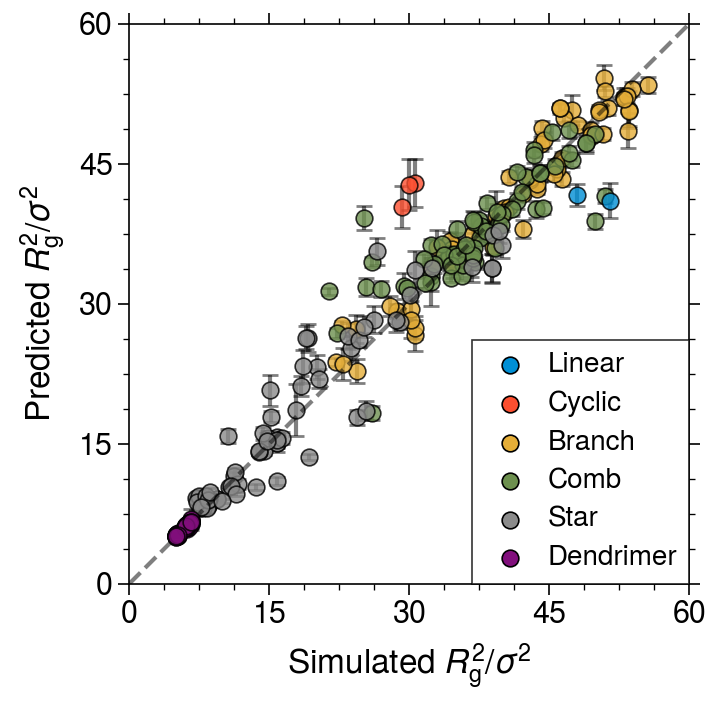

In [21]:
fig, ax = pplt.subplots(refwidth=2.8, refheight=2.8)

c_o_test = LE.inverse_transform(c_test)

for i in range(6):
    idx = np.where(c_o_test == NAMES[i])[0]
    if NAMES[i] == "linear" or NAMES[i] == "cyclic" or NAMES[i] == "dendrimer":
        zorder = 3 
    else:
        zorder = 1
    ax.scatter(y_test[idx], np.array(test_outs[1][1]).mean(axis=0)[idx,0], 
               c=COLORS[i], alpha=0.8, label=NAMES[i].capitalize(), edgecolor="k", zorder=zorder)
    ax.errorbar(y_test[idx], np.array(test_outs[1][1]).mean(axis=0)[idx,0],
                np.array(test_outs[1][1]).std(axis=0)[idx,0], fmt="none",
               c="k", alpha=0.5, zorder=0)

ax.plot([0, 60], [0, 60], "k--", alpha=0.5)

legend = ax.legend(ncols=1, loc="lower right")

for text in legend.get_texts():
    text.set_fontsize(10)

for handle in legend.legendHandles:
    handle.set_alpha(1)

ax.format(ylabel=r"Predicted $\mathit{R}_g^2/\mathit{\sigma}^2$", xlabel=r"Simulated $\mathit{R}_g^2/\mathit{\sigma}^2$",
          xlim=[0, 60], ylim=[0, 60],
          xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")

ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

ax.xaxis.set_tick_params(labelbottom=True, labeltop=False, top=True, bottom=True, which="both")
ax.yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")

fig.savefig(os.path.join(PLOT_DIR, "accuracy_parity_gnn.png"), dpi=300, bbox_inches="tight")

### Parity Plot Topo

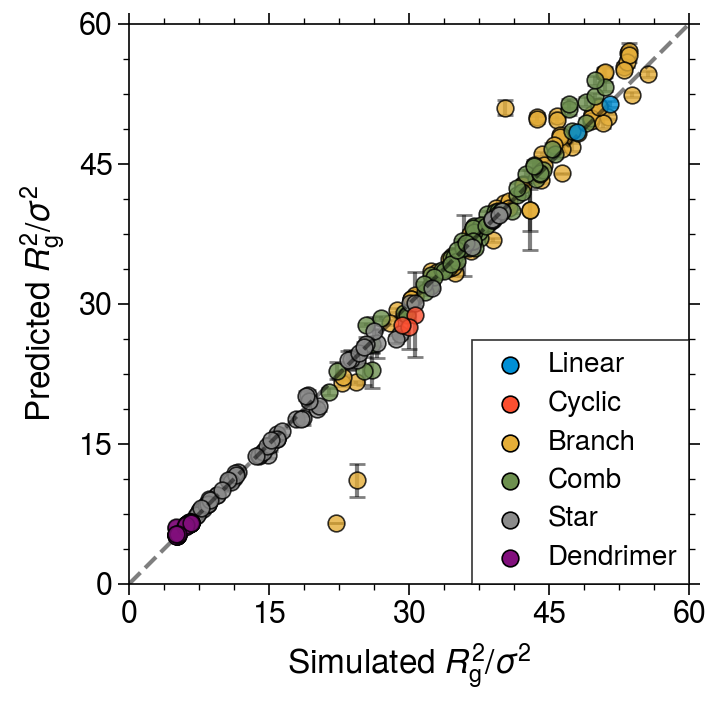

In [22]:
fig, ax = pplt.subplots(refwidth=2.8, refheight=2.8)

c_o_test = LE.inverse_transform(c_test)

for i in range(6):
    idx = np.where(c_o_test == NAMES[i])[0]
    if NAMES[i] == "linear" or NAMES[i] == "cyclic" or NAMES[i] == "dendrimer":
        zorder = 3 
    else:
        zorder = 1
    ax.scatter(y_test[idx], np.array(test_outs[2][1]).mean(axis=0)[idx,0], 
               c=COLORS[i], alpha=0.8, label=NAMES[i].capitalize(), edgecolor="k", zorder=zorder)
    ax.errorbar(y_test[idx], np.array(test_outs[2][1]).mean(axis=0)[idx,0],
                np.array(test_outs[2][1]).std(axis=0)[idx,0], fmt="none",
               c="k", alpha=0.5, zorder=0)

ax.plot([0, 60], [0, 60], "k--", alpha=0.5)

legend = ax.legend(ncols=1, loc="lower right")

for text in legend.get_texts():
    text.set_fontsize(10)

for handle in legend.legendHandles:
    handle.set_alpha(1)

ax.format(ylabel=r"Predicted $\mathit{R}_g^2/\mathit{\sigma}^2$", xlabel=r"Simulated $\mathit{R}_g^2/\mathit{\sigma}^2$",
          xlim=[0, 60], ylim=[0, 60],
          xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")

ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))

ax.xaxis.set_tick_params(labelbottom=True, labeltop=False, top=True, bottom=True, which="both")
ax.yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")


fig.savefig(os.path.join(PLOT_DIR, "accuracy_parity_topo.png"), dpi=300, bbox_inches="tight")


# Topology Classification Confusion Matrices

In [23]:
def transform_array(arr):
    c = np.zeros_like(arr)
    c[arr == 0]=2
    c[arr == 1]=3
    c[arr == 2]=1
    c[arr == 3]=5
    c[arr == 4]=0
    c[arr == 5]=4
    return c.astype("int")

with open(os.path.join(ANALYSIS_DIR, "all_outs.pickle"), "rb") as handle:
    train_outs = pickle.load(handle)
    valid_outs = pickle.load(handle)
    test_outs = pickle.load(handle)

### Confusion Matrix TopoGNN

In [ ]:
### cmap_name = "custom"
colors = [(1, 1, 1), (0, 0.56, 0.83)]
n_bins = [0, 1]
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

fig, ax = pplt.subplots(refwidth=2.8, refheight=2.8)

conf = np.zeros((6,6))
for i in range(10):
    conf += skm.confusion_matrix(transform_array(c_test), 
                                 transform_array(np.argmax(test_outs[0][2][i], axis=1)), normalize="true")
conf /= 10

conf = conf.T

mask = conf == 0

heatmap = ax.heatmap(conf, cmap="gray_r", vmin=0, vmax=1, edgecolor="tab:gray")

for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        if conf[i, j] > 0.01:
            if i == j:
                color = "w"
            else:
                color = "k"

            ax.text(
                j,  # X-coordinate (centered)
                i,  # Y-coordinate (centered)
                f"{conf[i, j]:.2f}",  # Text
                ha="center",  # Horizontal alignment
                va="center",  # Vertical alignment
                c=color,
                size=12
            )

ax.format(ylabel="Predicted Topology", xlabel="Simulated Topology",
          xticklabels=["Lin.", "Cyc.", "Brn.", "Comb", "Star", "Den." ],
          yticklabels=["Lin.", "Cyc.", "Brn.", "Comb", "Star", "Den." ],
          xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")



fig.savefig(os.path.join(PLOT_DIR, "accuracy_confusion.png"), dpi=300, bbox_inches="tight")


### Confusion Matrix Gnn

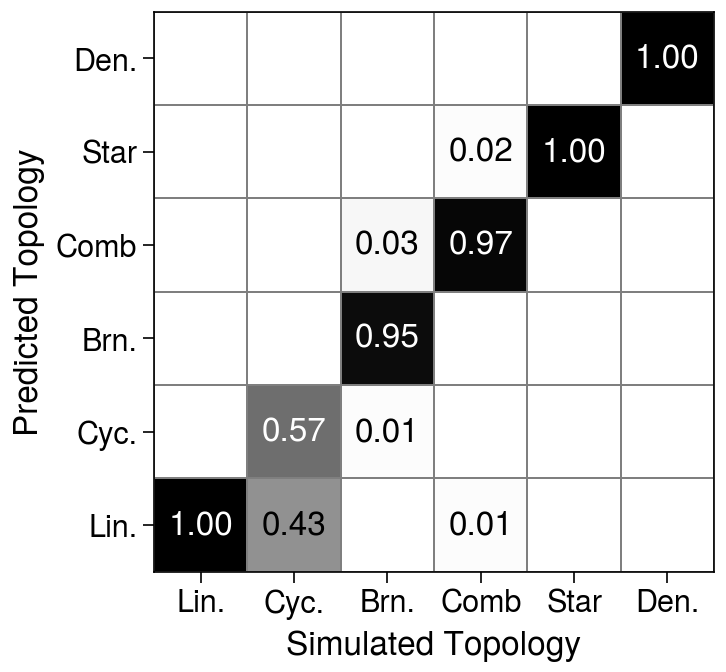

In [25]:
cmap_name = "custom"
colors = [(1, 1, 1), (0, 0.56, 0.83)]
n_bins = [0, 1]
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

fig, ax = pplt.subplots(refwidth=2.8, refheight=2.8)

conf = np.zeros((6,6))
for i in range(10):
    conf += skm.confusion_matrix(transform_array(c_test), 
                                 transform_array(np.argmax(test_outs[1][2][i], axis=1)), normalize="true")
conf /= 10

conf = conf.T

mask = conf == 0

heatmap = ax.heatmap(conf, cmap="gray_r", vmin=0, vmax=1, edgecolor="tab:gray")

for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        if conf[i, j] > 0.01:
            if i == j:
                color = "w"
            else:
                color = "k"

            ax.text(
                j,  # X-coordinate (centered)
                i,  # Y-coordinate (centered)
                f"{conf[i, j]:.2f}",  # Text
                ha="center",  # Horizontal alignment
                va="center",  # Vertical alignment
                c=color,
                size=12
            )

ax.format(ylabel="Predicted Topology", xlabel="Simulated Topology",
          xticklabels=["Lin.", "Cyc.", "Brn.", "Comb", "Star", "Den." ],
          yticklabels=["Lin.", "Cyc.", "Brn.", "Comb", "Star", "Den." ],
          xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")



fig.savefig(os.path.join(PLOT_DIR, "accuracy_confusion_gnn.png"), dpi=300, bbox_inches="tight")


### Confusion Matrix Topo

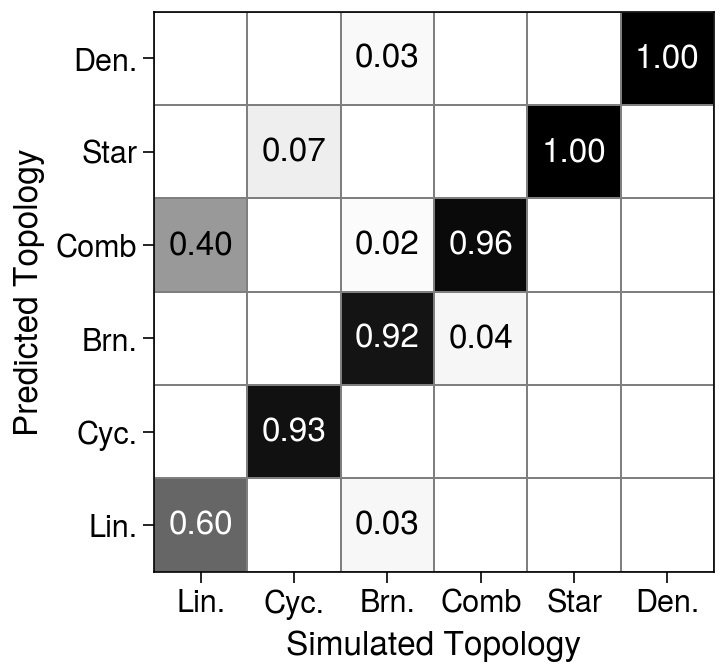

In [26]:
cmap_name = "custom"
colors = [(1, 1, 1), (0, 0.56, 0.83)]
n_bins = [0, 1]
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

fig, ax = pplt.subplots(refwidth=2.8, refheight=2.8)

conf = np.zeros((6,6))
for i in range(10):
    conf += skm.confusion_matrix(transform_array(c_test), 
                                 transform_array(np.argmax(test_outs[2][2][i], axis=1)), normalize="true")
conf /= 10

conf = conf.T

mask = conf == 0

heatmap = ax.heatmap(conf, cmap="gray_r", vmin=0, vmax=1, edgecolor="tab:gray")

for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        if conf[i, j] > 0.01:
            if i == j:
                color = "w"
            else:
                color = "k"

            ax.text(
                j,  # X-coordinate (centered)
                i,  # Y-coordinate (centered)
                f"{conf[i, j]:.2f}",  # Text
                ha="center",  # Horizontal alignment
                va="center",  # Vertical alignment
                c=color,
                size=12
            )

ax.format(ylabel="Predicted Topology", xlabel="Simulated Topology",
          xticklabels=["Lin.", "Cyc.", "Brn.", "Comb", "Star", "Den." ],
          yticklabels=["Lin.", "Cyc.", "Brn.", "Comb", "Star", "Den." ],
          xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")



fig.savefig(os.path.join(PLOT_DIR, "accuracy_confusion_topo.png"), dpi=300, bbox_inches="tight")


# Reconstruction Plot
### Blue is true, red is predicted.

In [40]:
with open(os.path.join(ANALYSIS_DIR, "test_recon.pickle"), "rb") as handle:
    x_pred = pickle.load(handle)

In [41]:
def obtain_idx(i):
    idx = np.where(c_o_test == NAMES[i])[0]
    baccs = []
    for j in idx:
        bacc = skm.balanced_accuracy_score(x_test[j].ravel(), np.round(x_pred[j].ravel()))
        baccs.append(bacc)
    rank = np.argsort(baccs)[::-1][15:19]
    idx = idx[rank]
    return idx

### Reconstruction Topo

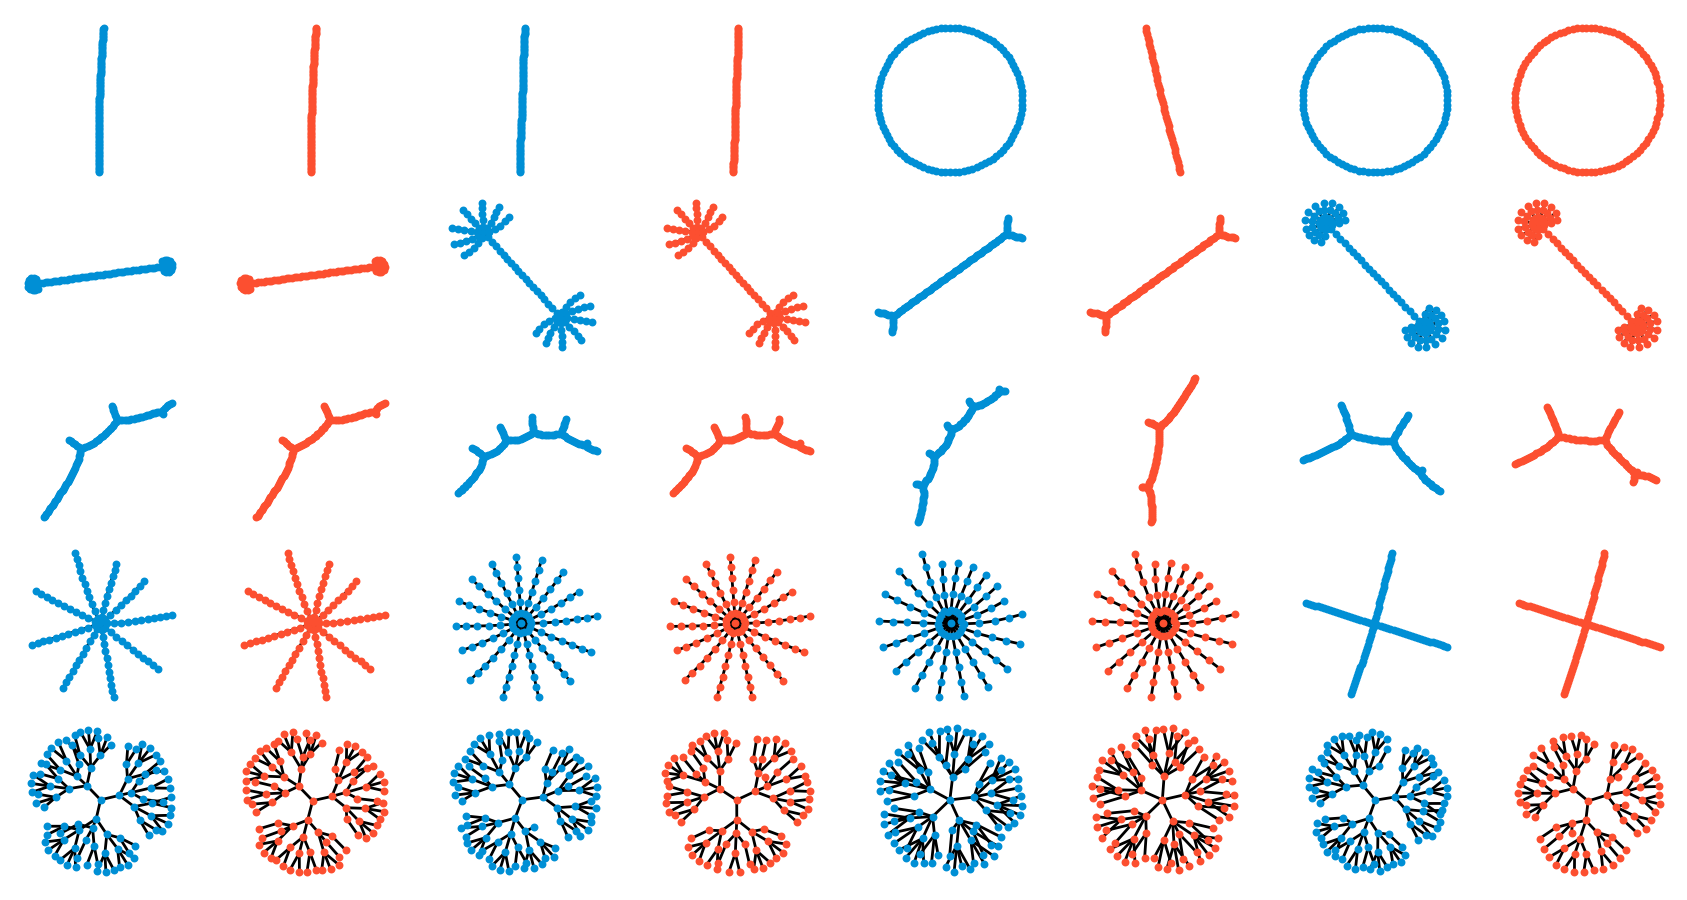

In [43]:
fig, ax = pplt.subplots(ncols=8, nrows=5, refheight=7/8, refwidth=7/8, wspace=1.5, hspace=0)

c_o_test = LE.inverse_transform(c_test)

for i in range(6):  
    idx = np.where(c_o_test == NAMES[i])[0]
    if i != 0 and i != 1:
        idx = obtain_idx(i)
        for j in range(4):
            idx_ = idx[j]
            G1 = graph_anneal_break_largest_circle(x_test[idx_])
            G2 = graph_anneal_break_largest_circle(x_pred[idx_])
            nx.draw(G1, pos=nx.kamada_kawai_layout(G1), node_size=5, ax=ax[((i-1)*4+j)*2], node_color=COLORS[0])
            nx.draw(G2, pos=nx.kamada_kawai_layout(G2), node_size=5, ax=ax[((i-1)*4+j)*2+1], node_color=COLORS[1])
    else:
        for j in range(2):
            idx_ = idx[j]
            G1 = graph_anneal_break_largest_circle(x_test[idx_])
            G2 = graph_anneal_break_largest_circle(x_pred[idx_])
            nx.draw(G1, pos=nx.kamada_kawai_layout(G1), node_size=5, ax=ax[(i*2+j)*2], node_color=COLORS[0])
            nx.draw(G2, pos=nx.kamada_kawai_layout(G2), node_size=5, ax=ax[(i*2+j)*2+1], node_color=COLORS[1])

fig.savefig(os.path.join(PLOT_DIR, "recon.png"), dpi=300, bbox_inches="tight")

### Reconstruction GNN

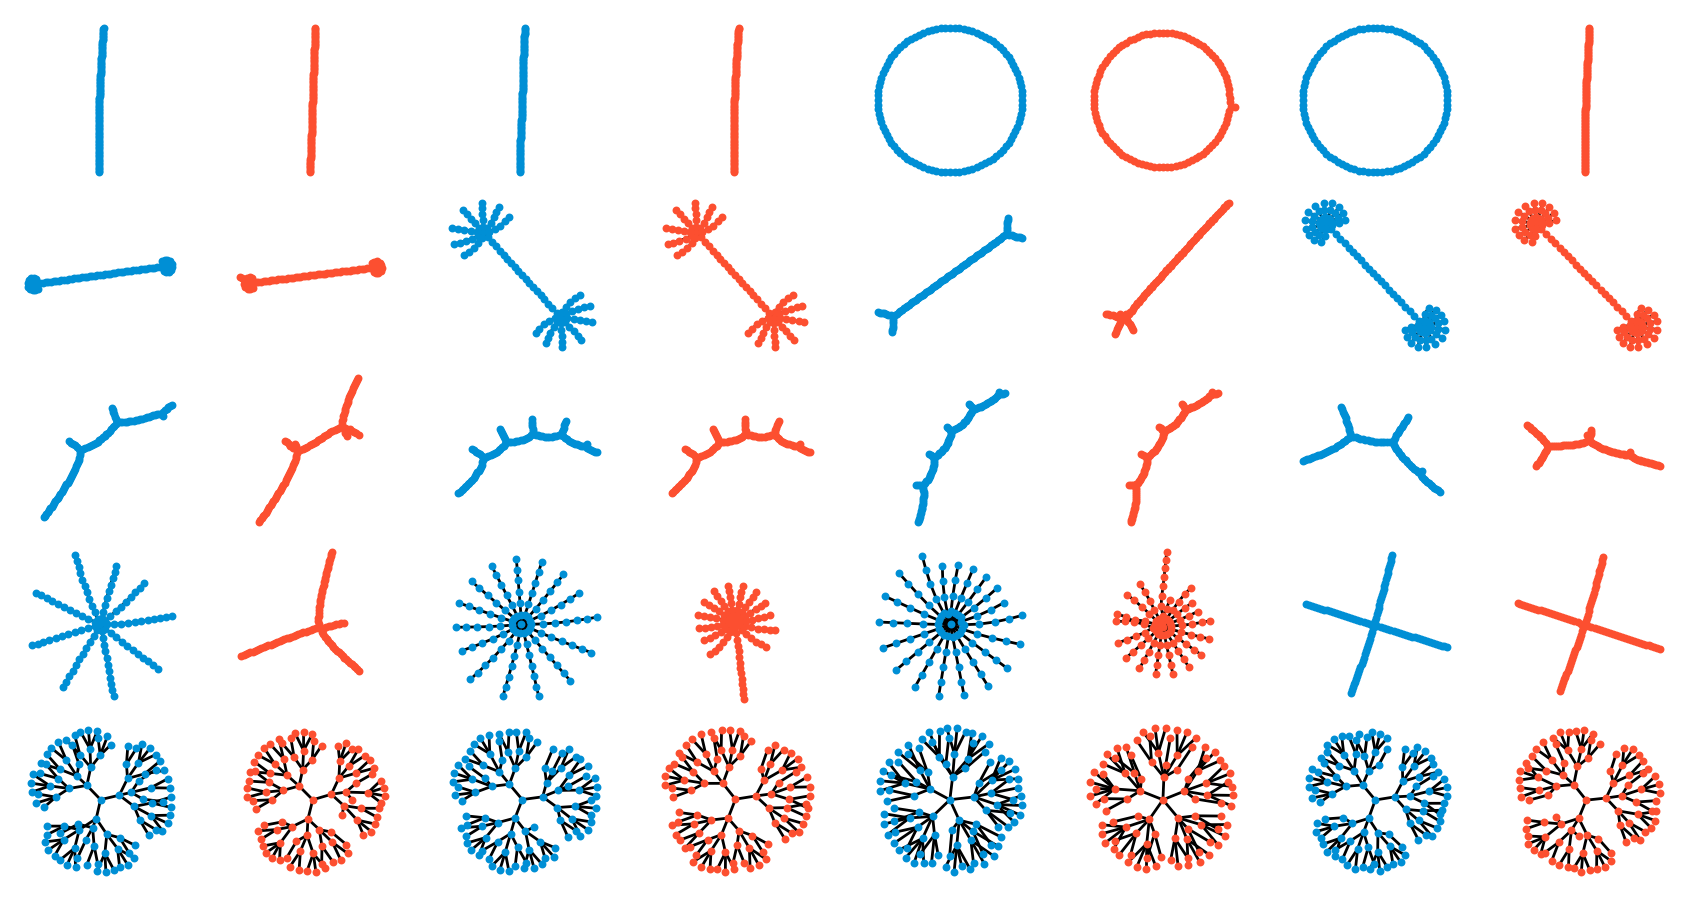

In [45]:
fig, ax = pplt.subplots(ncols=8, nrows=5, refheight=7/8, refwidth=7/8, wspace=1.5, hspace=0)

c_o_test = LE.inverse_transform(c_test)

for i in range(6):  
    idx = np.where(c_o_test == NAMES[i])[0]
    if i != 0 and i != 1:
        idx = obtain_idx(i)
        for j in range(4):
            idx_ = idx[j]
            G1 = graph_anneal_break_largest_circle(x_test[idx_])
            G2 = graph_anneal_break_largest_circle(test_outs[1][0][0][idx_])
            nx.draw(G1, pos=nx.kamada_kawai_layout(G1), node_size=5, ax=ax[((i-1)*4+j)*2], node_color=COLORS[0])
            nx.draw(G2, pos=nx.kamada_kawai_layout(G2), node_size=5, ax=ax[((i-1)*4+j)*2+1], node_color=COLORS[1])
    else:
        for j in range(2):
            idx_ = idx[j]
            G1 = graph_anneal_break_largest_circle(x_test[idx_])
            G2 = graph_anneal_break_largest_circle(test_outs[1][0][0][idx_])
            nx.draw(G1, pos=nx.kamada_kawai_layout(G1), node_size=5, ax=ax[(i*2+j)*2], node_color=COLORS[0])
            nx.draw(G2, pos=nx.kamada_kawai_layout(G2), node_size=5, ax=ax[(i*2+j)*2+1], node_color=COLORS[1])

fig.savefig(os.path.join(PLOT_DIR, "recon_gnn.png"), dpi=300, bbox_inches="tight")

### Reconstruction Topo

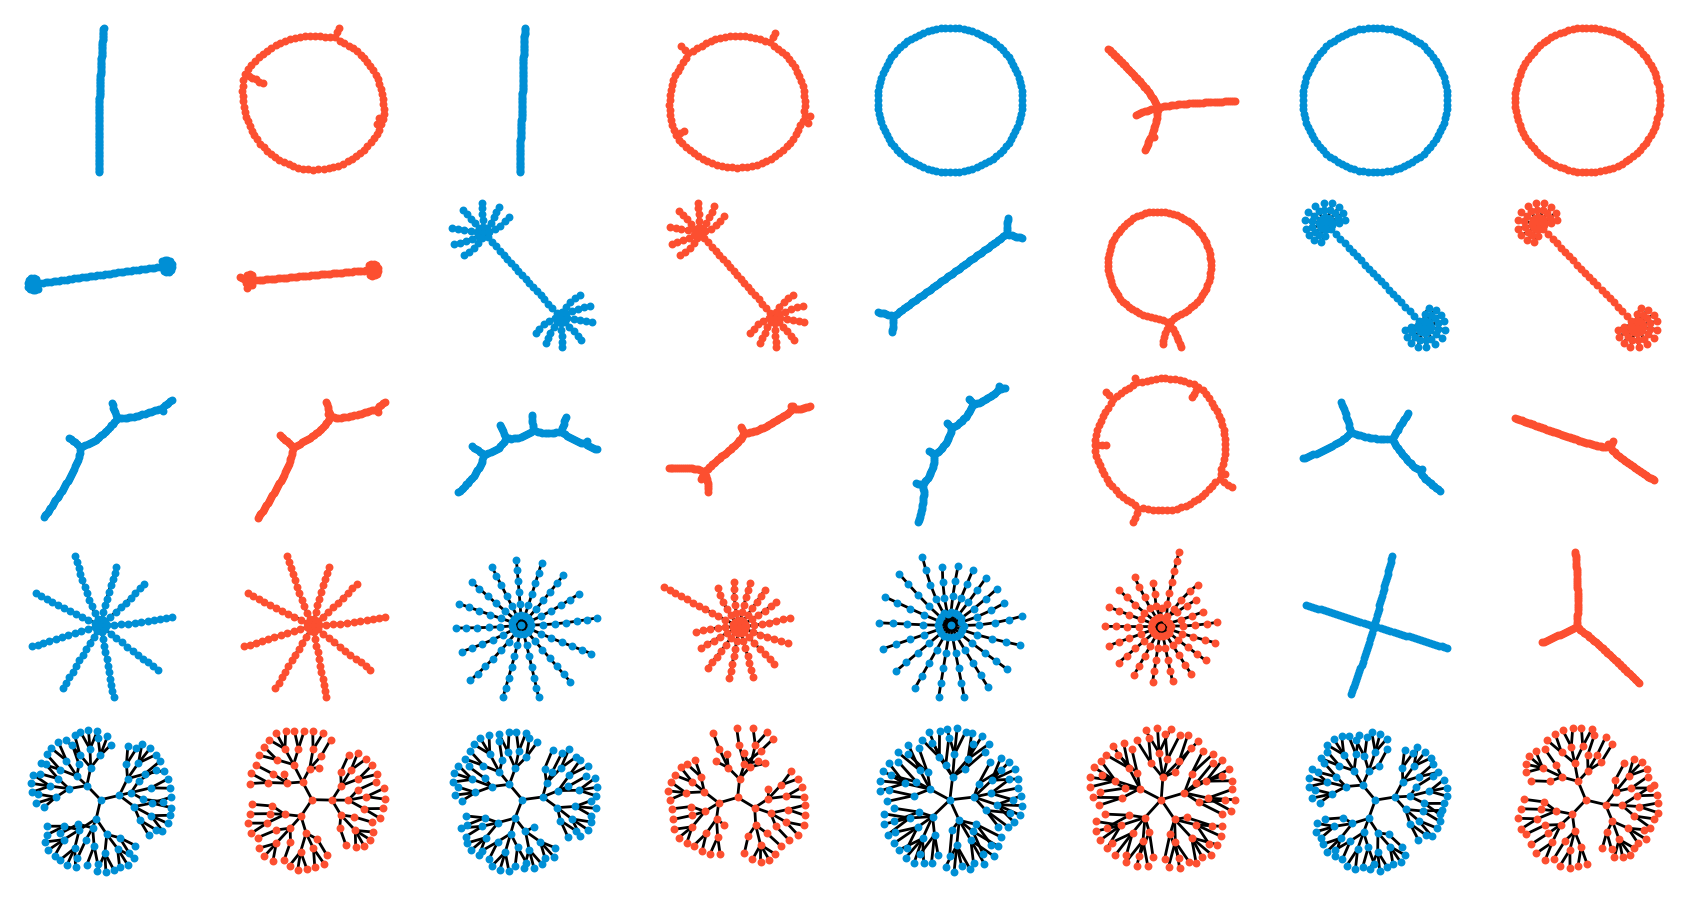

In [46]:
fig, ax = pplt.subplots(ncols=8, nrows=5, refheight=7/8, refwidth=7/8, wspace=1.5, hspace=0)

c_o_test = LE.inverse_transform(c_test)

for i in range(6):  
    idx = np.where(c_o_test == NAMES[i])[0]
    if i != 0 and i != 1:
        idx = obtain_idx(i)
        for j in range(4):
            idx_ = idx[j]
            G1 = graph_anneal_break_largest_circle(x_test[idx_])
            G2 = graph_anneal_break_largest_circle(test_outs[2][0][0][idx_])
            nx.draw(G1, pos=nx.kamada_kawai_layout(G1), node_size=5, ax=ax[((i-1)*4+j)*2], node_color=COLORS[0])
            nx.draw(G2, pos=nx.kamada_kawai_layout(G2), node_size=5, ax=ax[((i-1)*4+j)*2+1], node_color=COLORS[1])
    else:
        for j in range(2):
            idx_ = idx[j]
            G1 = graph_anneal_break_largest_circle(x_test[idx_])
            G2 = graph_anneal_break_largest_circle(test_outs[2][0][0][idx_])
            nx.draw(G1, pos=nx.kamada_kawai_layout(G1), node_size=5, ax=ax[(i*2+j)*2], node_color=COLORS[0])
            nx.draw(G2, pos=nx.kamada_kawai_layout(G2), node_size=5, ax=ax[(i*2+j)*2+1], node_color=COLORS[1])

fig.savefig(os.path.join(PLOT_DIR, "recon_topo.png"), dpi=300, bbox_inches="tight")

# Saliency Maps for Rg2 Regression

In [8]:
with open(os.path.join(ANALYSIS_DIR, "saliency.pickle"), "rb") as handle:
    grads = np.array(pickle.load(handle))[0]

ll = ["Number of nodes", "Number of edges", "Algebraic connectivity", "Diameter", "Radius", 
                    "Average degree", "Average neighbor degree", "Density", 
                    "Degree centrality", "Betweenness centrality", "Degree assortativity"]

ll = [ll[i] for i in [0, 1, 5, 6, 7, 3, 4, 2, 8, 9, 10]]

grads = grads[:, [0, 1, 5, 6, 7, 3, 4, 2, 8, 9, 10]]

### Saliency Map TopoGNN

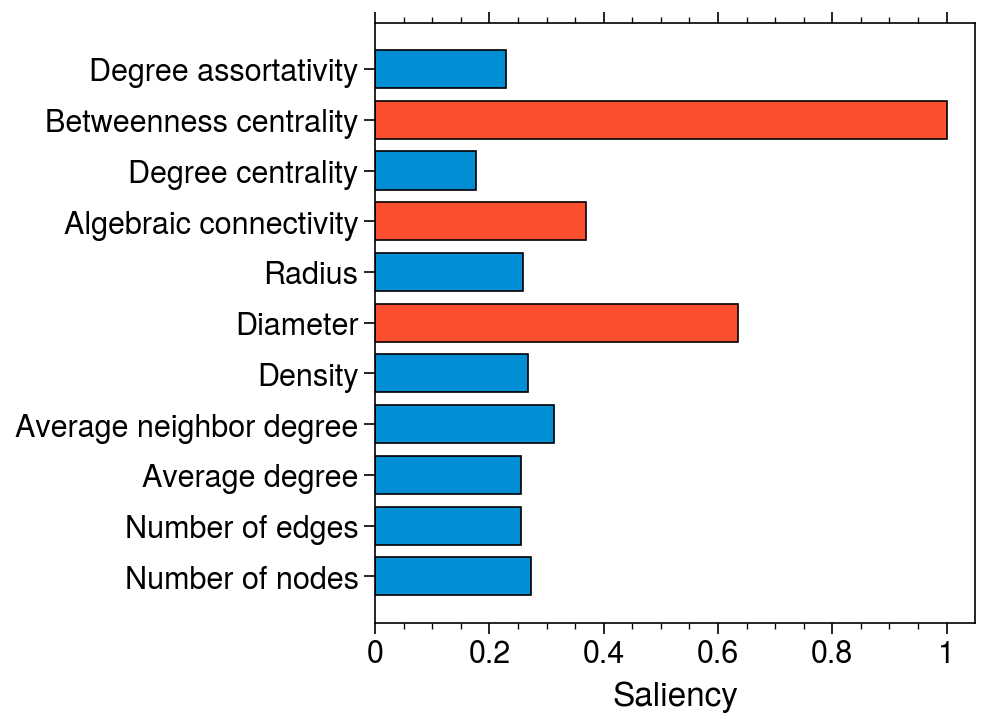

In [10]:
fig, ax = pplt.subplots(refwidth=3, refheight=3)

for i in range(11):
    if i == 5 or i == 7 or i == 9:
        color = COLORS[1]
    else:
        color = COLORS[0]
    ax.barh(i, grads.mean(axis=0)[i] / grads.mean(axis=0).max(), edgecolor="k", color=color, width=1.5)

    ax.set_xlabel("Saliency")
ax.set_yticks(np.arange(11))
ax.set_yticklabels(ll, rotation=0);

ax.format(xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")
ax.xaxis.set_tick_params(labeltop=False, labelbottom=True, top=True, bottom=True, which="both")
ax.yaxis.set_tick_params(left=False, right=False, which="minor")

fig.savefig(os.path.join(PLOT_DIR, "saliency.png"), dpi=300, bbox_inches="tight")

### Saliency Map Topo

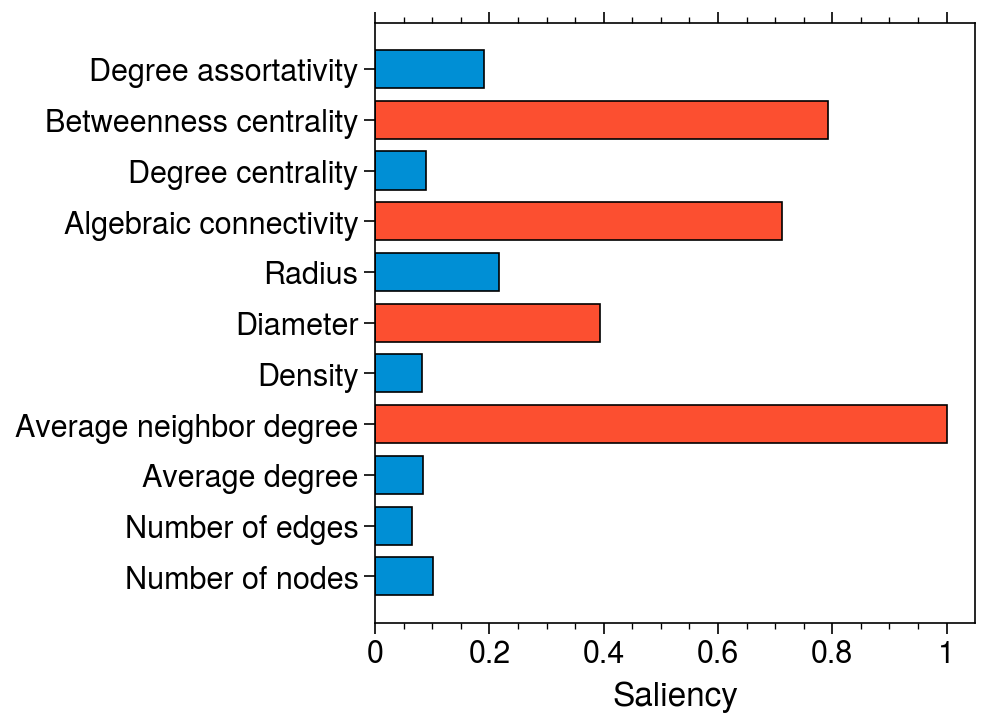

In [12]:
fig, ax = pplt.subplots(refwidth=3, refheight=3)


for i in range(11):
    if i == 5 or i == 7 or i == 9 or i == 3:
        color = COLORS[1]
    else:
        color = COLORS[0]
    ax.barh(i, grads.mean(axis=0)[i] / grads.mean(axis=0).max(), edgecolor="k", color=color, width=1.5)

    ax.set_xlabel("Saliency")
ax.set_yticks(np.arange(11))
ax.set_yticklabels(ll, rotation=0);

ax.format(xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")
ax.xaxis.set_tick_params(labeltop=False, labelbottom=True, top=True, bottom=True, which="both")
ax.yaxis.set_tick_params(left=False, right=False, which="minor")

fig.savefig(os.path.join(PLOT_DIR, "saliency_dnn.png"), dpi=300, bbox_inches="tight")

# UMAP for Latent Space Visualization

In [17]:
with open(os.path.join(ANALYSIS_DIR, "umap.pickle"), "rb") as handle:
    l_all = pickle.load(handle)
    umap = pickle.load(handle)

### UMAP TopoGNN

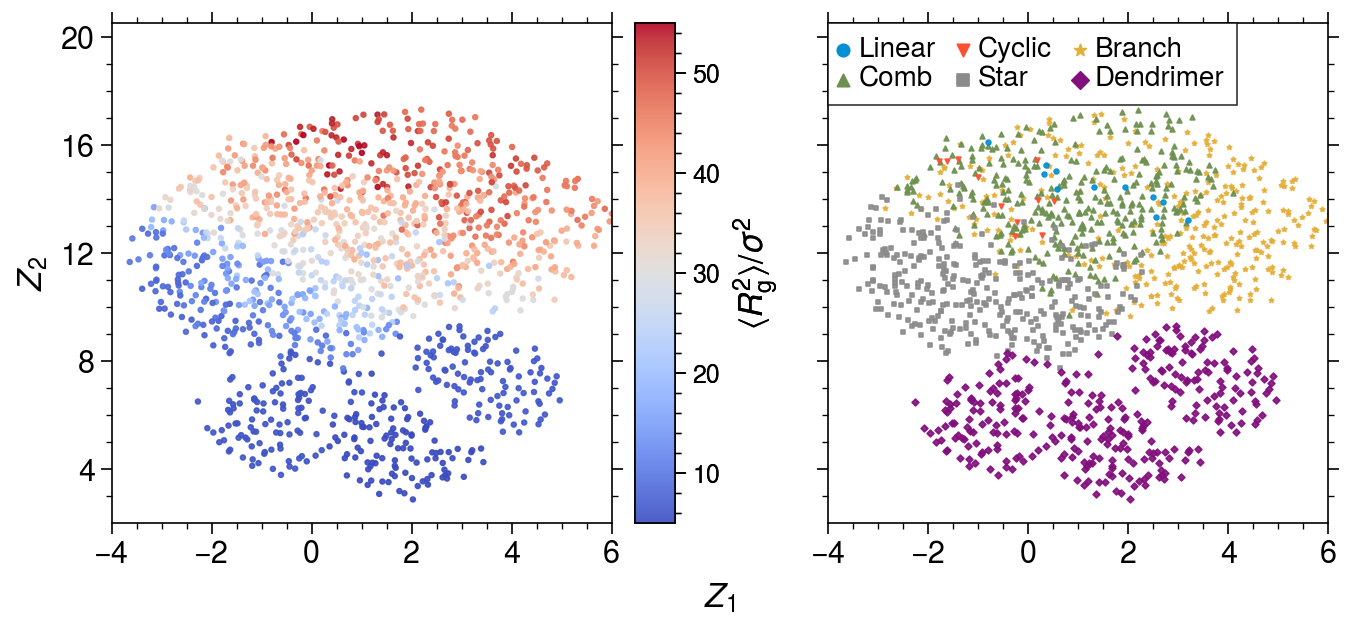

In [28]:
c_all = np.concatenate([c_train, c_valid, c_test])
y_all = np.concatenate([y_train, y_valid, y_test])

c_o_all = LE.inverse_transform(c_all)

fig, ax = pplt.subplots(refwidth=2.5, refheight=2.5, ncols=2)

im = ax[0].scatter(l_all[:, 0], l_all[:, 1], c=y_all, cmap="coolwarm", alpha=0.9, s=3, vmin=5, vmax=55)

cbar = ax[0].colorbar(im, loc="r", label=r"$\langle\mathit{R}_g^2\rangle/\mathit{\sigma}^2$", 
                      labelsize=12, minorticks=2)

markers = ["o", "v", "*", "^", "s", "D"]
for i in range(6):
    idx = np.where(c_o_all == NAMES[i])[0]
    if NAMES[i] == "linear" or NAMES[i] == "cyclic" or NAMES[i] == "dendrimer":
        zorder = 3 
    else:
        zorder = 1
    ax[1].scatter(l_all[idx, 0], l_all[idx, 1], c=COLORS[i], marker=markers[i],
                  alpha=0.9, zorder=zorder, s=3, label=NAMES[i].capitalize())
    
legend = ax[1].legend(loc="upper left", ncol=3, handlelength=0.2, columnspacing=1, labelspacing=.15)

for text in legend.get_texts():
    text.set_fontsize(10)

for handle in legend.legendHandles:
    handle.set_alpha(1)
    handle.set_alpha(1)
    handle.set_sizes([20])

for ax_ in ax:
    ax_.format(ylabel=r"$\mathit{Z}_2$", xlabel=r"$\mathit{Z}_1$", xlim=[-4, 6], ylim=[2, 20.5],
            xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")

    ax_.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax_.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))


    ax_.xaxis.set_tick_params(labelbottom=True, labeltop=False, top=True, bottom=True, which="both")
    ax_.yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")

fig.savefig(os.path.join(PLOT_DIR, "latent_umap.png"), dpi=300, bbox_inches="tight")

### Example Polymer Graph in UMAP
### Random Selection; reach run can be different

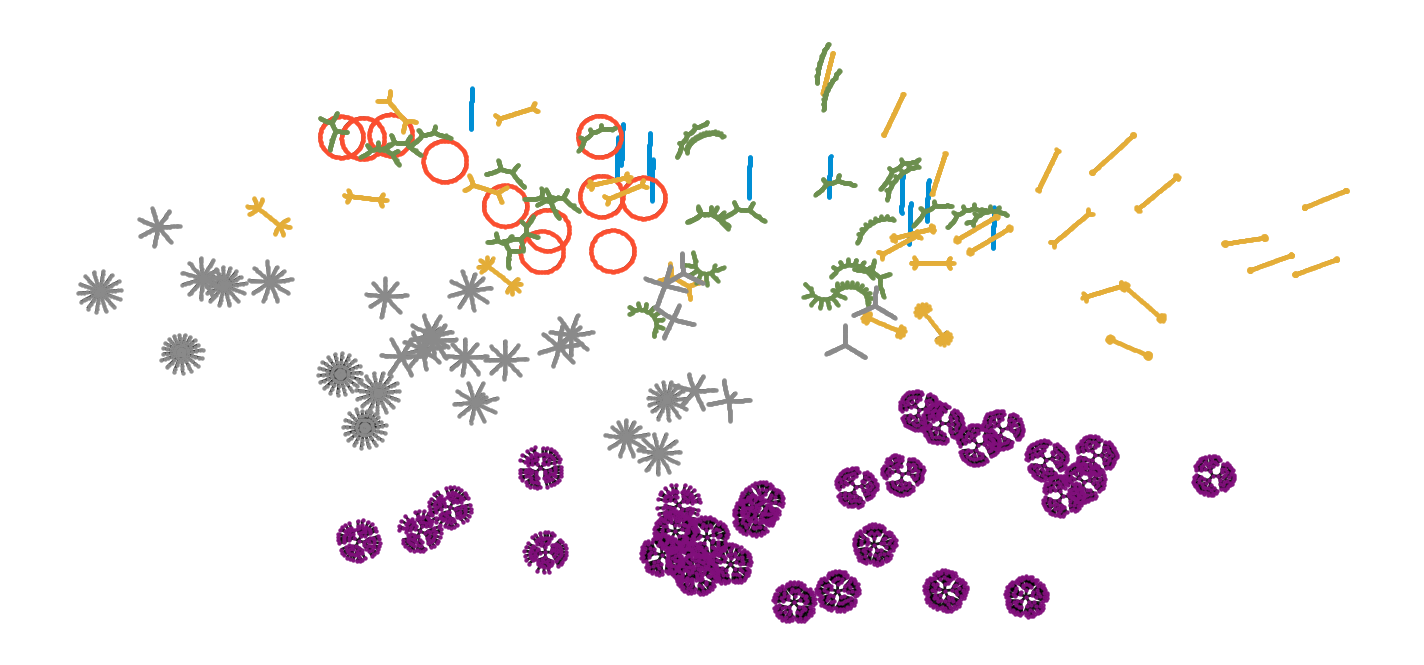

In [31]:
def check_overlap(new_pos, existing_positions, allowed_overlap=1):
    overlap_count = 0
    for pos in existing_positions:
        common_keys = set(new_pos.keys()).intersection(set(pos.keys()))
        if any(np.allclose(new_pos[key], pos[key]) for key in common_keys):
            overlap_count += 1
            if overlap_count > allowed_overlap:
                return True
    return False

c_all = np.concatenate([c_train, c_valid, c_test])
y_all = np.concatenate([y_train, y_valid, y_test])
graph_all = np.concatenate([graph_train, graph_valid, graph_test])

c_o_all = LE.inverse_transform(c_all)

fig, ax = pplt.subplots(refwidth=7, refheight=3.2)

scale_factor = 0.5
allowed_overlap = 1

for i in range(6):
    idx = np.where(c_o_all == NAMES[i])[0]
    
    idx_11 = []
    existing_positions = []

    while len(idx_11) < 30 and len(idx) > 0:
        j = np.random.choice(idx)
        idx = idx[idx != j]
        
        pos = nx.kamada_kawai_layout(graph_all[j])
        center_x = np.mean([x for x, y in pos.values()])
        center_y = np.mean([y for x, y in pos.values()])
        
        for key in pos.keys():
            pos[key] = ((pos[key][0] - center_x) * scale_factor * 2.3 / 7 + l_all[j, 0], 
                        (pos[key][1] - center_y) * scale_factor + l_all[j, 1])
        
        if not check_overlap(pos, existing_positions, allowed_overlap):
            idx_11.append(j)
            existing_positions.append(pos)

    for j in idx_11:
        nx.draw(graph_all[j], existing_positions[idx_11.index(j)], ax=ax, node_color=COLORS[i], node_size=1, alpha=0.9)


ax.format(xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")

fig.tight_layout()

fig.savefig(os.path.join(PLOT_DIR, "latent_umap_large.png"), dpi=300, bbox_inches="tight")

### UMAP GNN

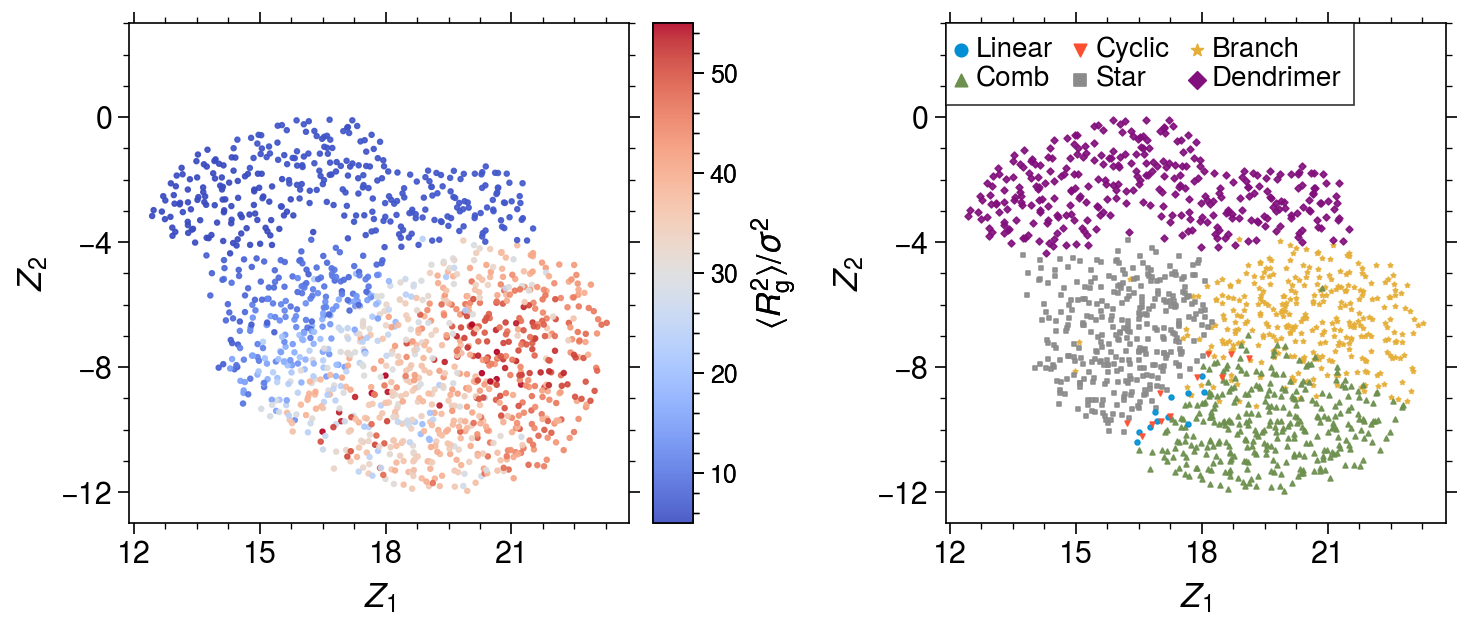

In [33]:
with open(os.path.join(ANALYSIS_DIR, "umap_gnn.pickle"), "rb") as handle:
    l_all = pickle.load(handle)
    umap = pickle.load(handle)

c_all = np.concatenate([c_train, c_valid, c_test])
y_all = np.concatenate([y_train, y_valid, y_test])

c_o_all = LE.inverse_transform(c_all)

fig, ax = pplt.subplots(refwidth=2.5, refheight=2.5, ncols=2, share=False)

im = ax[0].scatter(l_all[:, 0], l_all[:, 1], c=y_all, cmap="coolwarm", alpha=0.9, s=3, vmin=5, vmax=55)

cbar = ax[0].colorbar(im, loc="r", label=r"$\langle\mathit{R}_g^2\rangle/\mathit{\sigma}^2$", 
                      labelsize=12, minorticks=2)

markers = ["o", "v", "*", "^", "s", "D"]

for i in range(6):
    idx = np.where(c_o_all == NAMES[i])[0]
    if NAMES[i] == "linear" or NAMES[i] == "cyclic" or NAMES[i] == "dendrimer":
        zorder = 3 
    else:
        zorder = 1
    ax[1].scatter(l_all[idx, 0], l_all[idx, 1], c=COLORS[i], marker=markers[i],
                  alpha=0.9, zorder=zorder, s=3, label=NAMES[i].capitalize())
    
legend = ax[1].legend(loc="upper left", ncol=3, handlelength=0.2, columnspacing=1, labelspacing=.15)

for text in legend.get_texts():
    text.set_fontsize(10)

for handle in legend.legendHandles:
    handle.set_alpha(1)
    handle.set_alpha(1)
    handle.set_sizes([20])

for ax_ in ax:
    ax_.format(ylabel=r"$\mathit{Z}_2$", xlabel=r"$\mathit{Z}_1$", ylim=[-13, 3],
            xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")

    ax_.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax_.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))


    ax_.xaxis.set_tick_params(labelbottom=True, labeltop=False, top=True, bottom=True, which="both")
    ax_.yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")

fig.savefig(os.path.join(PLOT_DIR, "latent_umap_gnn.png"), dpi=300, bbox_inches="tight")

### UMAP Topo

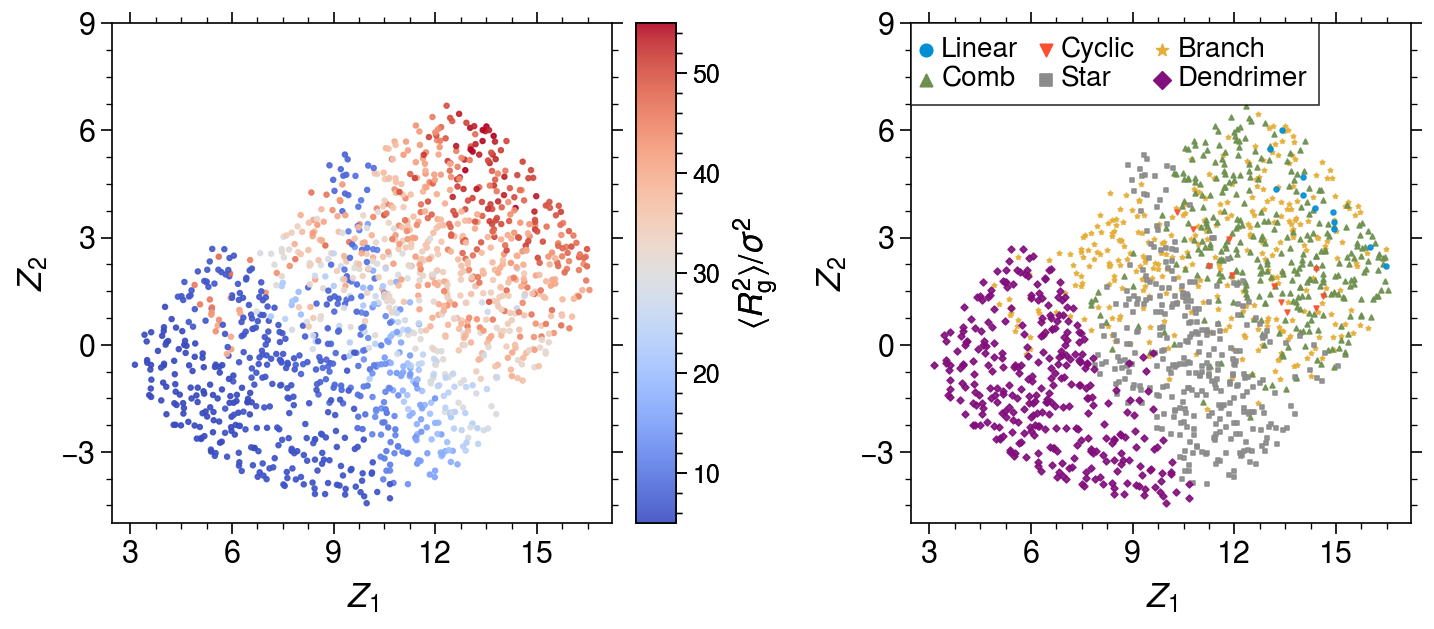

In [34]:
with open(os.path.join(ANALYSIS_DIR, "umap_topo.pickle"), "rb") as handle:
    l_all = pickle.load(handle)
    umap = pickle.load(handle)

c_all = np.concatenate([c_train, c_valid, c_test])
y_all = np.concatenate([y_train, y_valid, y_test])

c_o_all = LE.inverse_transform(c_all)

fig, ax = pplt.subplots(refwidth=2.5, refheight=2.5, ncols=2, share=False)

im = ax[0].scatter(l_all[:, 0], l_all[:, 1], c=y_all, cmap="coolwarm", alpha=0.9, s=3, vmin=5, vmax=55)

cbar = ax[0].colorbar(im, loc="r", label=r"$\langle\mathit{R}_g^2\rangle/\mathit{\sigma}^2$", 
                      labelsize=12, minorticks=2)

markers = ["o", "v", "*", "^", "s", "D"]
for i in range(6):
    idx = np.where(c_o_all == NAMES[i])[0]
    if NAMES[i] == "linear" or NAMES[i] == "cyclic" or NAMES[i] == "dendrimer":
        zorder = 3 
    else:
        zorder = 1
    ax[1].scatter(l_all[idx, 0], l_all[idx, 1], c=COLORS[i], marker=markers[i],
                  alpha=0.9, zorder=zorder, s=3, label=NAMES[i].capitalize())
    
legend = ax[1].legend(loc="upper left", ncol=3, handlelength=0.2, columnspacing=1, labelspacing=.15)

for text in legend.get_texts():
    text.set_fontsize(10)

for handle in legend.legendHandles:
    handle.set_alpha(1)
    handle.set_alpha(1)
    handle.set_sizes([20])

for ax_ in ax:
    ax_.format(ylabel=r"$\mathit{Z}_2$", xlabel=r"$\mathit{Z}_1$", ylim=[-5, 9],
            xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")

    ax_.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax_.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))


    ax_.xaxis.set_tick_params(labelbottom=True, labeltop=False, top=True, bottom=True, which="both")
    ax_.yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")

fig.savefig(os.path.join(PLOT_DIR, "latent_umap_topo.png"), dpi=300, bbox_inches="tight")

### UMAP No Regression No Classification

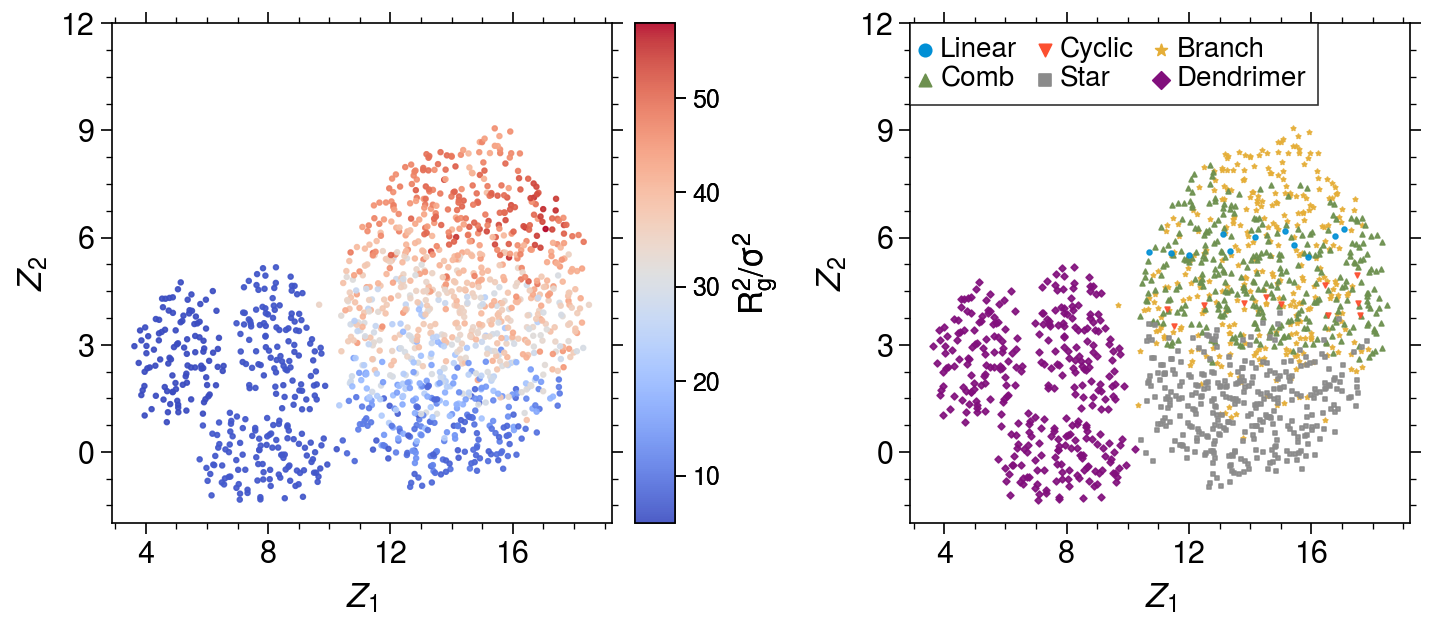

In [35]:
with open(os.path.join(ANALYSIS_DIR, "umap_reg_false_cls_false.pickle"), "rb") as handle:
    l_all = pickle.load(handle)
    umap = pickle.load(handle)

markers = ["o", "v", "*", "^", "s", "D"]

c_all = np.concatenate([c_train, c_valid, c_test])
y_all = np.concatenate([y_train, y_valid, y_test])

c_o_all = LE.inverse_transform(c_all)

fig, ax = pplt.subplots(refwidth=2.5, refheight=2.5, ncols=2, share=False)

im = ax[0].scatter(l_all[:, 0], l_all[:, 1], c=y_all, cmap="coolwarm", alpha=0.9, s=3)
cbar = plt.colorbar(im, ax=ax[0], title="$R_g^2/\sigma^2$", labelsize=12)


for i in range(6):
    idx = np.where(c_o_all == NAMES[i])[0]
    if NAMES[i] == "linear" or NAMES[i] == "cyclic" or NAMES[i] == "dendrimer":
        zorder = 3 
    else:
        zorder = 1
    ax[1].scatter(l_all[idx, 0], l_all[idx, 1], c=COLORS[i], marker=markers[i],
                  alpha=0.9, zorder=zorder, s=3, label=NAMES[i].capitalize())
    
legend = ax[1].legend(loc="upper left", ncol=3, handlelength=0.2, columnspacing=1, labelspacing=.15)

for text in legend.get_texts():
    text.set_fontsize(10)

for handle in legend.legendHandles:
    handle.set_alpha(1)
    handle.set_alpha(1)
    handle.set_sizes([20])

for ax_ in ax:
    ax_.format(ylabel=r"$\mathit{Z}_2$", xlabel=r"$\mathit{Z}_1$", ylim=[-2, 12],
            xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")

    ax_.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax_.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))


    ax_.xaxis.set_tick_params(labelbottom=True, labeltop=False, top=True, bottom=True, which="both")
    ax_.yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")

fig.savefig(os.path.join(PLOT_DIR, "latent_umap_reg_false_cls_false.png"), dpi=300, bbox_inches="tight")

### UMAP No Classification Only

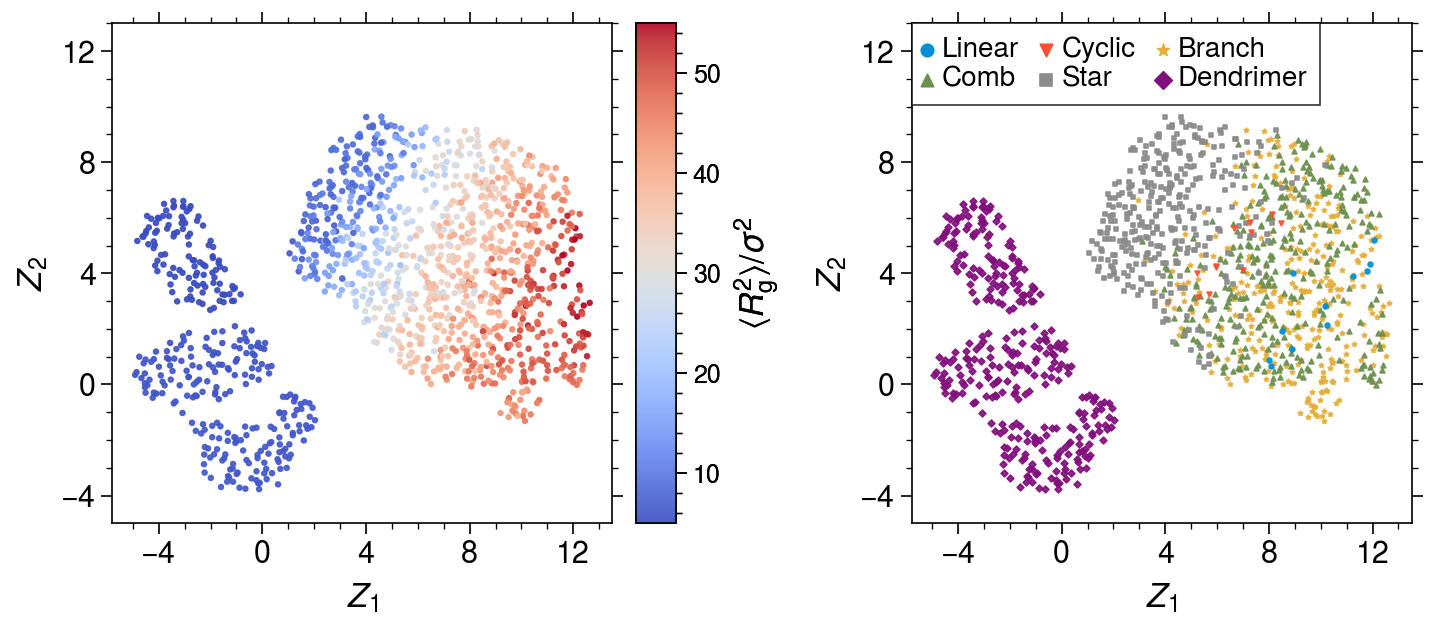

In [37]:
with open(os.path.join(ANALYSIS_DIR, "umap_reg_true_cls_false.pickle"), "rb") as handle:
    l_all = pickle.load(handle)
    umap = pickle.load(handle)

c_all = np.concatenate([c_train, c_valid, c_test])
y_all = np.concatenate([y_train, y_valid, y_test])

c_o_all = LE.inverse_transform(c_all)

fig, ax = pplt.subplots(refwidth=2.5, refheight=2.5, ncols=2, share=False)

im = ax[0].scatter(l_all[:, 0], l_all[:, 1], c=y_all, cmap="coolwarm", alpha=0.9, s=3, vmin=5, vmax=55)

cbar = ax[0].colorbar(im, loc="r", label=r"$\langle\mathit{R}_g^2\rangle/\mathit{\sigma}^2$", 
                      labelsize=12, minorticks=2)

markers = ["o", "v", "*", "^", "s", "D"]
for i in range(6):
    idx = np.where(c_o_all == NAMES[i])[0]
    if NAMES[i] == "linear" or NAMES[i] == "cyclic" or NAMES[i] == "dendrimer":
        zorder = 3 
    else:
        zorder = 1
    ax[1].scatter(l_all[idx, 0], l_all[idx, 1], c=COLORS[i], marker=markers[i],
                  alpha=0.9, zorder=zorder, s=3, label=NAMES[i].capitalize())
    
legend = ax[1].legend(loc="upper left", ncol=3, handlelength=0.2, columnspacing=1, labelspacing=.15)

for text in legend.get_texts():
    text.set_fontsize(10)

for handle in legend.legendHandles:
    handle.set_alpha(1)
    handle.set_alpha(1)
    handle.set_sizes([20])

for ax_ in ax:
    ax_.format(ylabel=r"$\mathit{Z}_2$", xlabel=r"$\mathit{Z}_1$", ylim=[-5, 13],
            xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")

    ax_.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax_.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))


    ax_.xaxis.set_tick_params(labelbottom=True, labeltop=False, top=True, bottom=True, which="both")
    ax_.yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")

fig.savefig(os.path.join(PLOT_DIR, "latent_umap_reg_true_cls_false.png"), dpi=300, bbox_inches="tight")

### UMAP No Regression Only

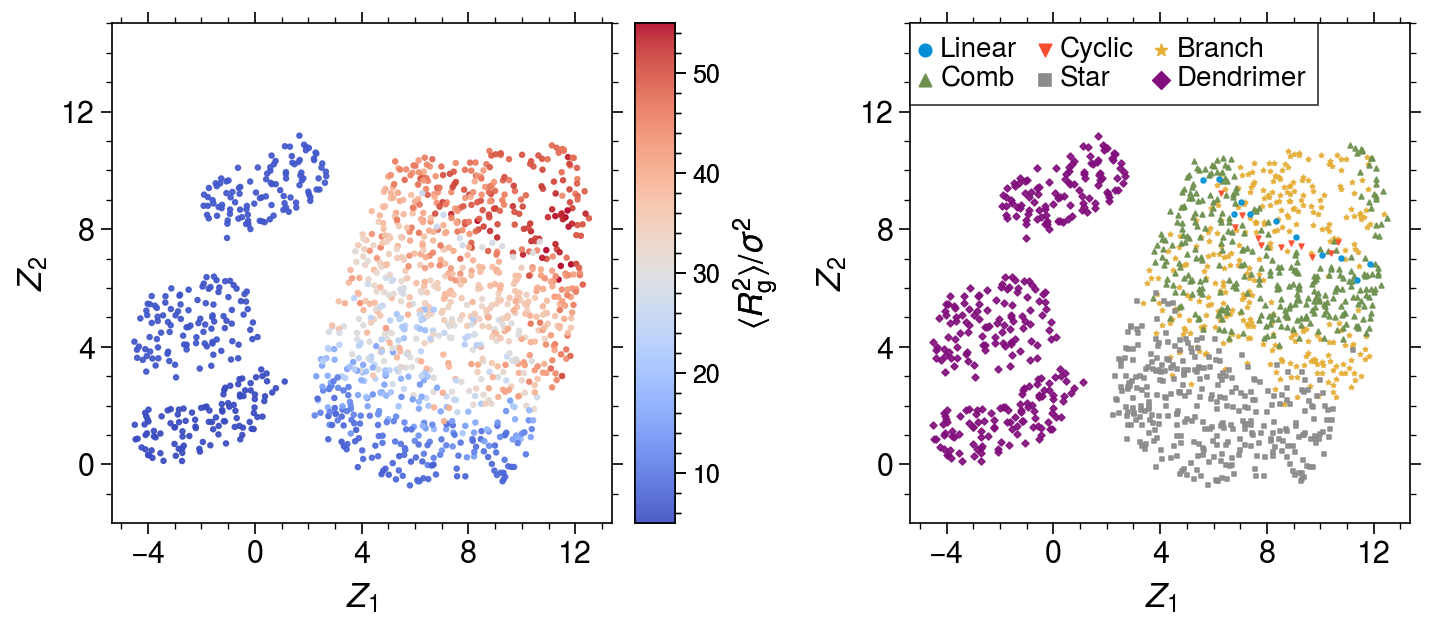

In [39]:
with open(os.path.join(ANALYSIS_DIR, "umap_reg_false_cls_true.pickle"), "rb") as handle:
    l_all = pickle.load(handle)
    umap = pickle.load(handle)

c_all = np.concatenate([c_train, c_valid, c_test])
y_all = np.concatenate([y_train, y_valid, y_test])

c_o_all = LE.inverse_transform(c_all)

fig, ax = pplt.subplots(refwidth=2.5, refheight=2.5, ncols=2, share=False)
im = ax[0].scatter(l_all[:, 0], l_all[:, 1], c=y_all, cmap="coolwarm", alpha=0.9, s=3, vmin=5, vmax=55)

cbar = ax[0].colorbar(im, loc="r", label=r"$\langle\mathit{R}_g^2\rangle/\mathit{\sigma}^2$", 
                      labelsize=12, minorticks=2)

markers = ["o", "v", "*", "^", "s", "D"]
for i in range(6):
    idx = np.where(c_o_all == NAMES[i])[0]
    if NAMES[i] == "linear" or NAMES[i] == "cyclic" or NAMES[i] == "dendrimer":
        zorder = 3 
    else:
        zorder = 1
    ax[1].scatter(l_all[idx, 0], l_all[idx, 1], c=COLORS[i], marker=markers[i],
                  alpha=0.9, zorder=zorder, s=3, label=NAMES[i].capitalize())
    
legend = ax[1].legend(loc="upper left", ncol=3, handlelength=0.2, columnspacing=1, labelspacing=.15)

for text in legend.get_texts():
    text.set_fontsize(10)

for handle in legend.legendHandles:
    handle.set_alpha(1)
    handle.set_alpha(1)
    handle.set_sizes([20])

for ax_ in ax:
    ax_.format(ylabel=r"$\mathit{Z}_2$", xlabel=r"$\mathit{Z}_1$", ylim=[-2, 15],
            xlabelsize=12, ylabelsize=12, xticklabelsize=11, yticklabelsize=11, grid="off")

    ax_.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax_.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))


    ax_.xaxis.set_tick_params(labelbottom=True, labeltop=False, top=True, bottom=True, which="both")
    ax_.yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")

fig.savefig(os.path.join(PLOT_DIR, "latent_umap_reg_false_cls_true.png"), dpi=300, bbox_inches="tight")

# Random Polymer Generation from TopoGNN Latent Space UMAP

### Fix Z1, Increase Z2; Vertical Line

In [56]:
with open(os.path.join(ANALYSIS_DIR, "umap_1_4_1_16.pickle"), "rb") as handle:
    outputs = pickle.load(handle)

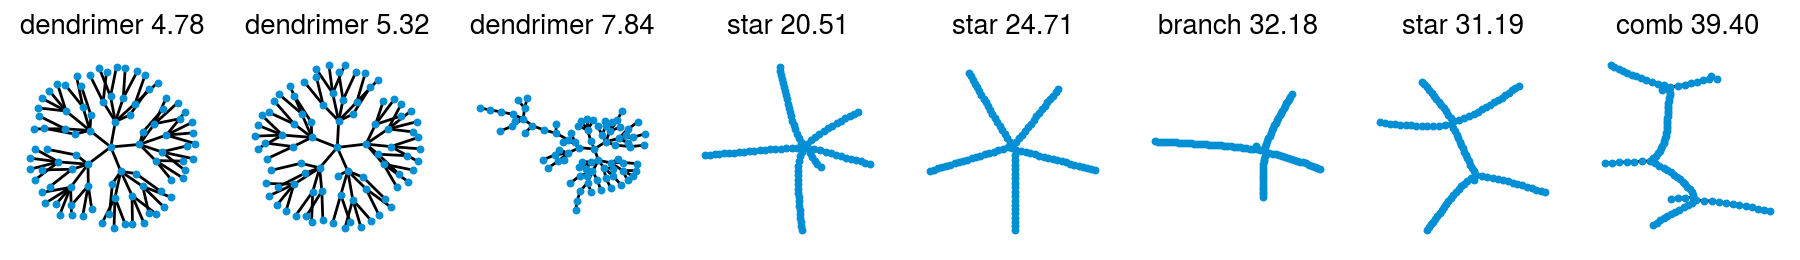

In [58]:
fig, ax = pplt.subplots(ncols=8, nrows=1, refwidth=1, refheight=1)
for i in range(8):
    nx.draw(outputs[2*i+1][3], pos=nx.kamada_kawai_layout(outputs[2*i+1][3]), 
            node_size=5, ax=ax[i], node_color=COLORS[0])
    ax[i].set_title(f"{outputs[i*2+1][-4]} {outputs[2*i+1][-2]:0.2f}")

fig.savefig(os.path.join(PLOT_DIR, "umap_vertical_examples.png"), dpi=300, bbox_inches="tight")

### Fix Z2, Increase Z1; Horizontal Line

In [61]:
with open(os.path.join(ANALYSIS_DIR, "umap_-3_12_6_12.pickle"), "rb") as handle:
    outputs = pickle.load(handle)

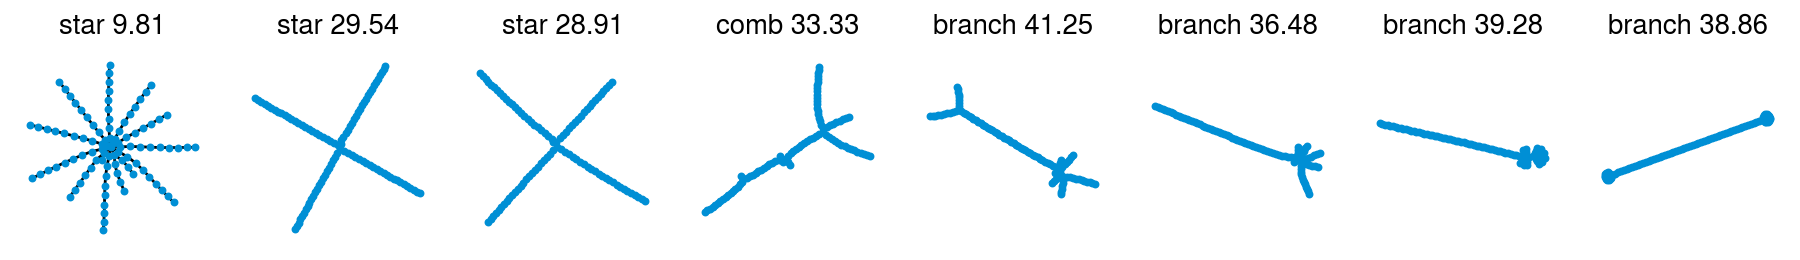

In [64]:
fig, ax = pplt.subplots(ncols=8, nrows=1, refwidth=1, refheight=1)
n = 0
for i in [0, 1, 2, 4, 7, 8, 10, 12]:
    nx.draw(outputs[i][3], pos=nx.kamada_kawai_layout(outputs[i][3]), 
            node_size=5, ax=ax[n], node_color=COLORS[0])
    
    ax[n].set_title(f"{outputs[i][-4]} {outputs[i][-2]:0.2f}")
    n += 1

fig.savefig(os.path.join(PLOT_DIR, "umap_horizontal_examples.png"), dpi=300, bbox_inches="tight")

# Rg² Targeted Polymer Generation

### Rg² = 30

In [70]:
with open(os.path.join(ANALYSIS_DIR, "gen_star_30_all.pickle"), "rb") as handle:
    o1 = pickle.load(handle)

with open(os.path.join(ANALYSIS_DIR, "gen_branch_30_all.pickle"), "rb") as handle:
    o2 = pickle.load(handle)

with open(os.path.join(ANALYSIS_DIR, "gen_comb_30_all.pickle"), "rb") as handle:
    o3 = pickle.load(handle)

with open(os.path.join(ANALYSIS_DIR, "gen_cyclic_30_all.pickle"), "rb") as handle:
    o4 = pickle.load(handle)

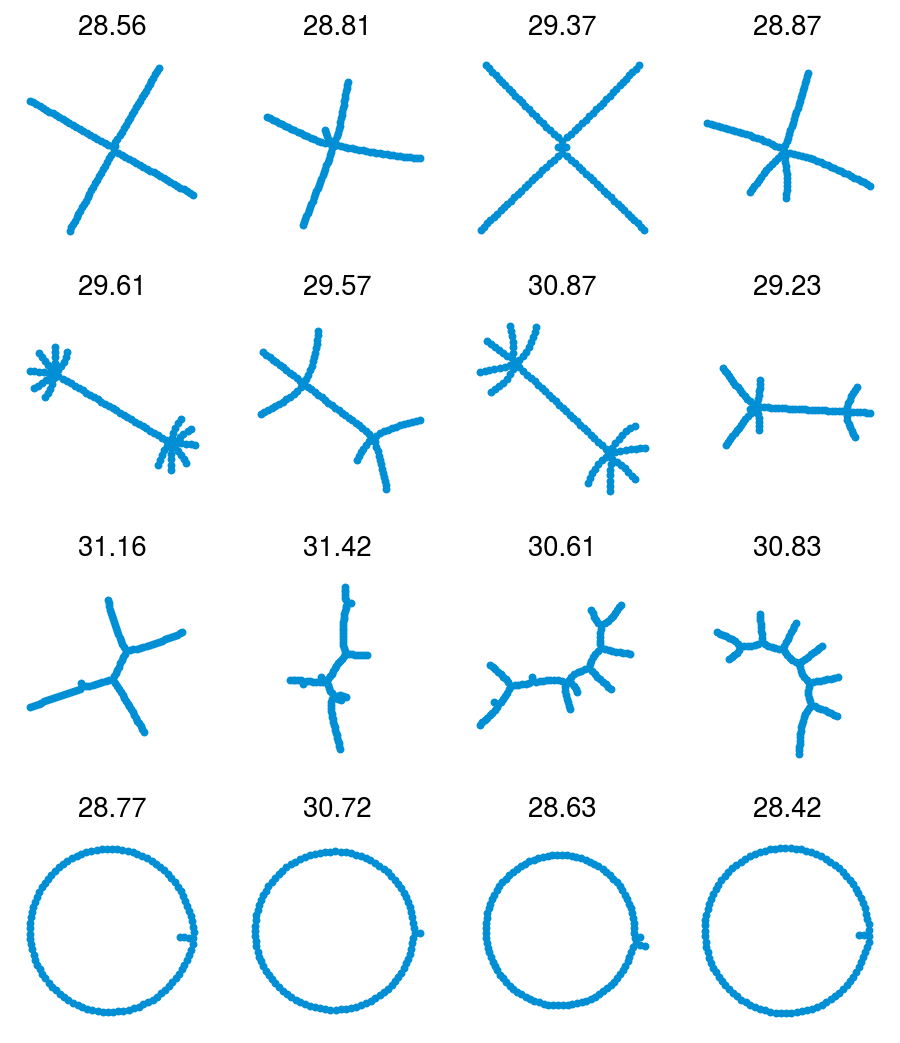

In [75]:
e1 = [o1[i] for i in [0, 1, 68, 66]]

e2 = [o2[i] for i in [14, 35, 53, 22]]

e3 = [o3[i] for i in [0, 1, 2, 3]]

e4 = [o4[i] for i in [0, 1, 2, 3]]

example = e1 + e2 + e3 + e4

fig, ax = pplt.subplots(ncols=4, nrows=4, refwidth=1, refheight=1)

for i in range(16):
    nx.draw(example[i][2], pos=nx.kamada_kawai_layout(example[i][2]), 
            node_size=5, ax=ax[i], node_color=COLORS[0])
    
    ax[i].set_title(f"{str(example[i][6])[:5]}")

fig.savefig(os.path.join(PLOT_DIR, "topo_gen_30.png"), dpi=300, bbox_inches="tight")

### Rg² = 50

In [82]:
with open(os.path.join(ANALYSIS_DIR, "gen_branch_50_all.pickle"), "rb") as handle:
    o1 = pickle.load(handle)

with open(os.path.join(ANALYSIS_DIR, "gen_comb_50_all.pickle"), "rb") as handle:
    o2 = pickle.load(handle)

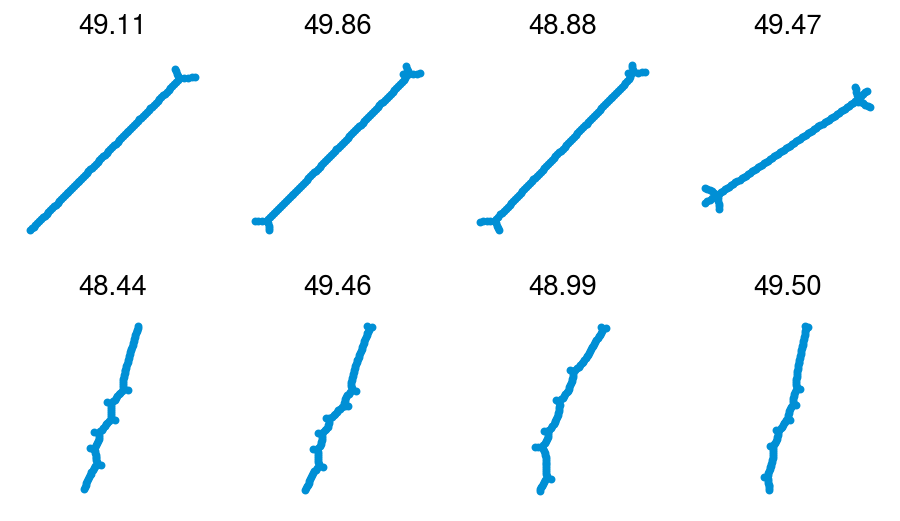

In [85]:
e1 = [o1[i] for i in [0, 1, 2, 7]]

e2 = [o2[i] for i in [0, 2, 4, 5]]

example = e1 + e2

fig, ax = pplt.subplots(ncols=4, nrows=2, refwidth=1, refheight=1)

for i in range(8):
    nx.draw(example[i][2], pos=nx.kamada_kawai_layout(example[i][2]), 
            node_size=5, ax=ax[i], node_color=COLORS[0])

    ax[i].set_title(f"{str(example[i][6])[:5]}")

fig.savefig(os.path.join(PLOT_DIR, "topo_gen_50.png"), dpi=300, bbox_inches="tight")

### Rg² = 7.5

In [86]:
with open(os.path.join(ANALYSIS_DIR, "gen_star_7.5_all.pickle"), "rb") as handle:
    o1 = pickle.load(handle)

with open(os.path.join(ANALYSIS_DIR, "gen_dendrimer_7.5_all.pickle"), "rb") as handle:
    o2 = pickle.load(handle)

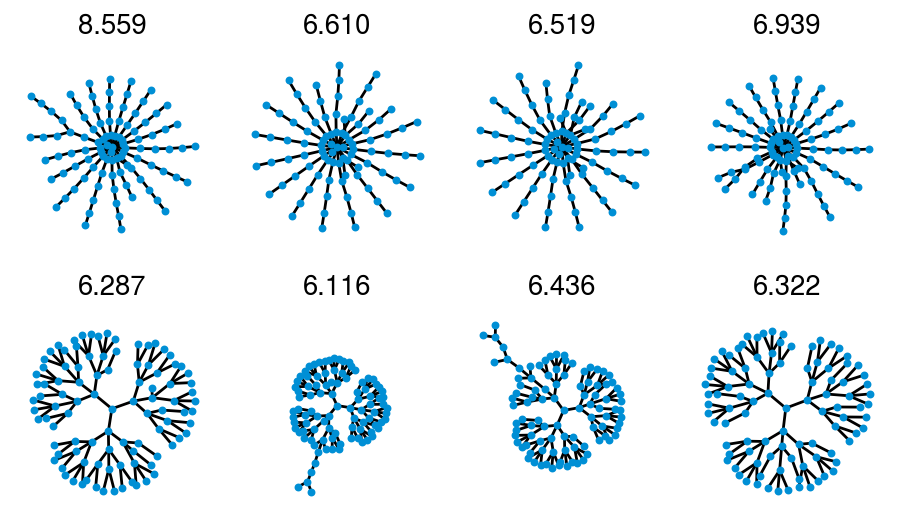

In [88]:
e1 = [o1[i] for i in [0, 1, 2, 3]]

e2 = [o2[i] for i in [0, 1, 2, 3]]

example = e1 + e2

fig, ax = pplt.subplots(ncols=4, nrows=2, refwidth=1, refheight=1)

for i in range(8):
    nx.draw(example[i][2], pos=nx.kamada_kawai_layout(example[i][2]), 
            node_size=5, ax=ax[i], node_color=COLORS[0])
    ax[i].set_title(f"{str(example[i][6])[:5]}")

fig.savefig(os.path.join(PLOT_DIR, "topo_gen_7.5.png"), dpi=300, bbox_inches="tight")

# Shear Viscosity of Generated Polymers with Rg² ~ 20

In [114]:
def find_intersections(x, y, y2):
    diff = y - y2

    sign_changes = np.where(np.diff(np.sign(diff)))[0]

    intersections = []

    for i in sign_changes:
        x0, x1 = x[i], x[i+1]
        y0, y1 = diff[i], diff[i+1]
        
        intersect_x = x0 - y0 * (x1 - x0) / (y1 - y0)
        intersections.append(intersect_x)

    return intersections

In [122]:
tops = ["star_28.56110382", "branch_29.23610878", "comb_30.83162880", "cyclic_28.77655983"]
rhos = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

def read_data_files(pattern):
    files = sorted(glob.glob(pattern))
    return [pd.read_csv(file, delim_whitespace=True, comment='#', header=None).values.squeeze() for file in files]

def aggregate_data(tops, file_name):
    return np.array([read_data_files(os.path.join(ANALYSIS_DIR, f"gen_30_visco/{top}/*/{file_name}")) for top in tops])


etass = aggregate_data(tops, "visco_result.dat")
sacfss = aggregate_data(tops, "sacf.dat")
gfitss = aggregate_data(tops, "G_fit.dat")

etas, sacfs, gfits = etass.squeeze(), sacfss.squeeze(), gfitss.squeeze()

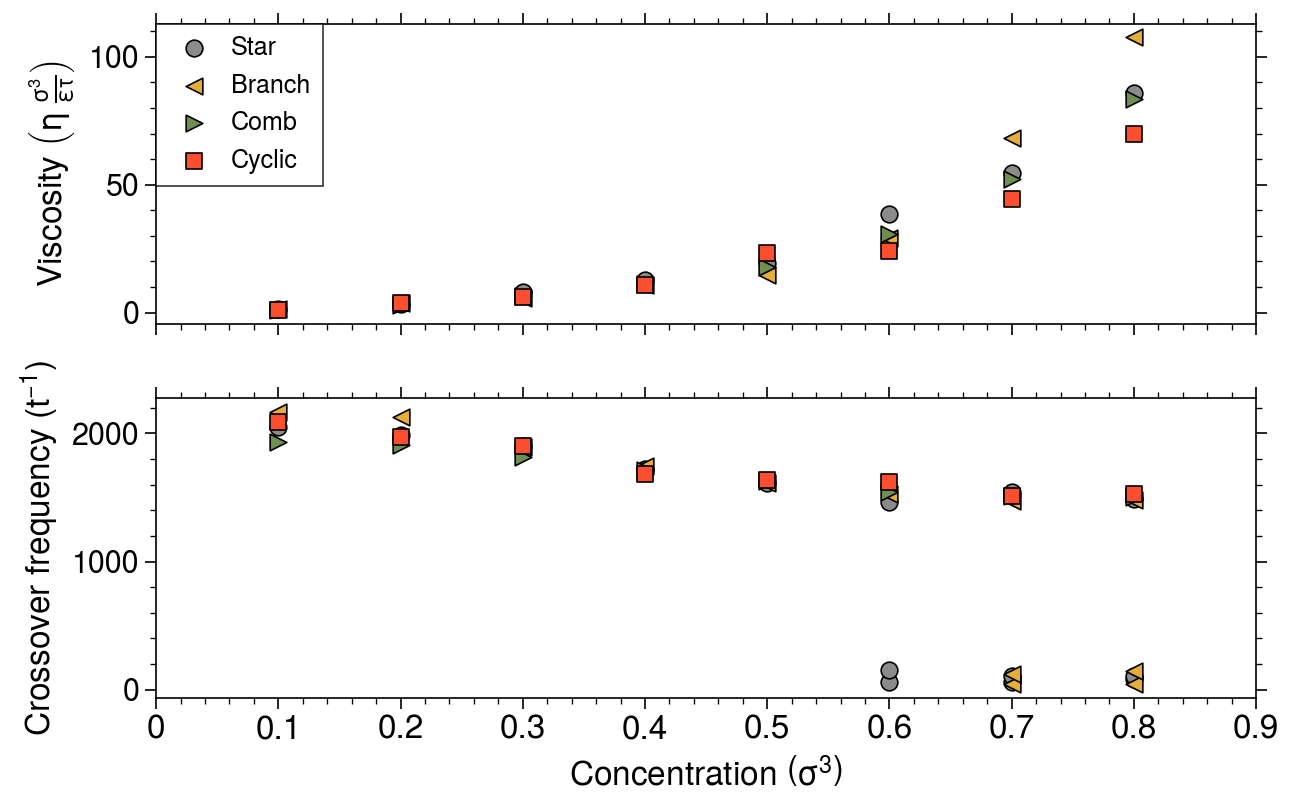

In [125]:
fig, ax = pplt.subplots(refwidth=5.5, refheight=1.5, nrows=2, ncols=1, sharey=False)

cololos = [COLORS[4], COLORS[2], COLORS[3], COLORS[1]]

markers = ["o", "<", ">", "s"]

for i in range(4):
    ax[0].scatter(np.array(rhos), etas[i, :, 1], marker=markers[i], color=cololos[i], edgecolor="k", label=tops[i].split("_")[0].capitalize())

ax[0].legend(ncol=1)

ax[0].format(ylabel=r"Viscosity $\left( \eta \ \frac{\sigma^3}{\epsilon \tau}\right)$",  xlim=[0.0, 0.9], grid="off",
                xlabelsize=12, ylabelsize=12, xticklabelsize=12, yticklabelsize=11)
ax[0].yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")
ax[0].xaxis.set_tick_params(labeltop=False, labelbottom=False, top=True, bottom=True, which="both")


names = ["Star", "Branch", "Comb", "Cyclic"]

cololos = [COLORS[4], COLORS[2], COLORS[3], COLORS[1]]

markers = ["o", "<", ">", "s"]

for k, top in enumerate(tops):
    for i, rho in enumerate(rhos):

        files = sorted(glob.glob(os.path.join(ANALYSIS_DIR, f"gen_30_visco/{top}/rho_{rho}/G_star.dat")))

        xs = []
        y1s = []
        y2s = []
        for file in files:
            df1 = pd.read_csv(file, delim_whitespace=True, comment="#", header=None)
            xs.append(df1[0].values)
            y1s.append(df1[1].values)
            y2s.append(df1[2].values)

        xs = np.array(xs).squeeze()
        y1s = np.array(y1s).squeeze()
        y2s = np.array(y2s).squeeze()
            

        intersections = find_intersections(xs, y1s, y2s)
        
        n_inter = len(intersections)
        if i == 0:
            ax[1].scatter(np.ones(n_inter) * rho, intersections, color=cololos[k], marker=markers[k], label=tops[k].split("_")[0].capitalize(), edgecolor="k")
        else:
            ax[1].scatter(np.ones(n_inter) * rho, intersections, color=cololos[k], marker=markers[k], edgecolor="k")


ax[1].format(ylabel=r"Crossover frequency ($t^{-1}$)", xlabel=r"Concentration $\left( \sigma^3 \right)$", xlim=[0.0, 0.9], grid="off",
                xlabelsize=12, ylabelsize=12, xticklabelsize=12, yticklabelsize=11)

ax[1].yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")
ax[1].xaxis.set_tick_params(labeltop=False, labelbottom=True, top=True, bottom=True, which="both")

fig.savefig(os.path.join(PLOT_DIR, "complex_moduli.png"), dpi=300, bbox_inches="tight")

### Storage and Loss Modulii

In [128]:
rhos_list = [[0.8], [0.1]]  

def read_and_process_files(top, rho):
    pattern = os.path.join(ANALYSIS_DIR, f"gen_30_visco/{top}/rho_{rho}/G_star.dat")
    files = sorted(glob.glob(pattern))

    xs, y1s, y2s = [], [], []
    for file in files:
        data = pd.read_csv(file, delim_whitespace=True, comment='#', header=None)
        xs.append(data[0].values)
        y1s.append(data[1].values)
        y2s.append(data[2].values)

    return np.array(xs).squeeze(), np.array(y1s).squeeze(), np.array(y2s).squeeze()


results = [[], []]

for i, rhos in enumerate(rhos_list):
    for top in tops:
        for rho in rhos:
            xs, y1s, y2s = read_and_process_files(top, rho)
            results[i].append((xs, y1s, y2s))

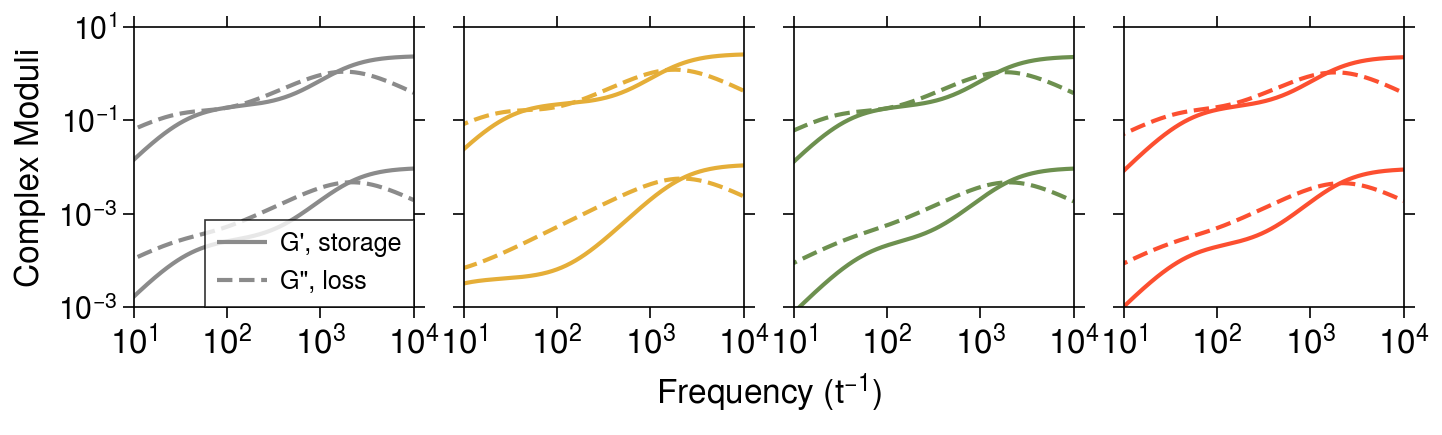

In [135]:
fig, ax = pplt.subplots(refwidth=1.4, refheight=1.4, ncols=4, nrows=1, wspace=2)
for i in range(4):
    ax[i].loglog(results[0][i][0], results[0][i][1], label=r"G', storage", color=cololos[i])
    ax[i].loglog(results[0][i][0], results[0][i][2], "--", label=r'G", loss', color=cololos[i])

    ax[i].loglog(results[1][i][0], results[1][i][1], color=cololos[i])
    ax[i].loglog(results[1][i][0], results[1][i][2], "--", color=cololos[i])

    if i == 0:
        ax[i].legend(loc="lower right", ncols=1)

    ax[i].format(xlabel=r"Frequency ($t^{-1}$)", ylabel=r"Complex Moduli", xlim=[1e1, 1e4], ylim=[1e-5, 10], grid="off",
                    xlabelsize=12, ylabelsize=12, xticklabelsize=12, yticklabelsize=11)

    ax[i].yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")
    ax[i].xaxis.set_tick_params(labeltop=False, labelbottom=True, top=True, bottom=True, which="both")

    ax[i].set_xticks([1e1, 1e2, 1e3, 1e4])
    ax[i].set_xticklabels([r"$10^1$", r"10$^2$", r"10$^3$", r"10$^4$"])

    ax[i].set_yticks([1e-5, 1e-3, 1e-1, 1e1])
    ax[i].set_yticklabels([r"$10^{-3}$", r"$10^{-3}$", r"10$^{-1}$", r"10$^1$"])

fig.savefig(os.path.join(PLOT_DIR, "complex_moduli_2.png"), dpi=300, bbox_inches="tight")

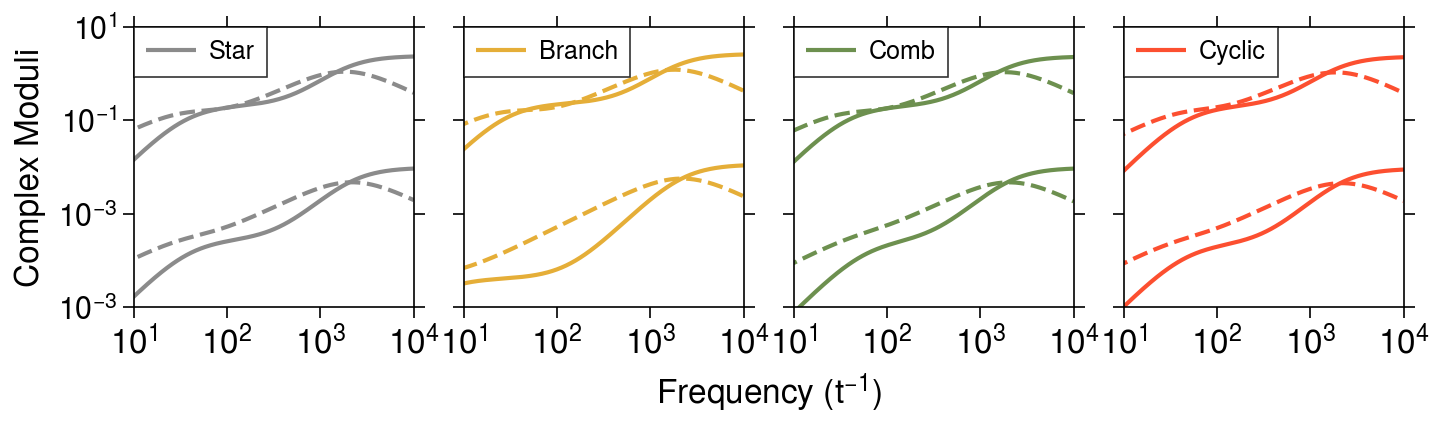

In [137]:
fig, ax = pplt.subplots(refwidth=1.4, refheight=1.4, ncols=4, nrows=1, wspace=2)
for i in range(4):
    ax[i].loglog(results[0][i][0], results[0][i][1], label=tops[i].split("_")[0].capitalize(), color=cololos[i])
    ax[i].loglog(results[0][i][0], results[0][i][2], "--", color=cololos[i])

    ax[i].loglog(results[1][i][0], results[1][i][1], color=cololos[i])
    ax[i].loglog(results[1][i][0], results[1][i][2], "--", color=cololos[i])


    ax[i].legend(loc="upper left", ncols=1)

    ax[i].format(xlabel=r"Frequency ($t^{-1}$)", ylabel=r"Complex Moduli", xlim=[1e1, 1e4], ylim=[1e-5, 10], grid="off",
                    xlabelsize=12, ylabelsize=12, xticklabelsize=12, yticklabelsize=11)

    ax[i].yaxis.set_tick_params(labelleft=True, labelright=False, left=True, right=True, which="both")
    ax[i].xaxis.set_tick_params(labeltop=False, labelbottom=True, top=True, bottom=True, which="both")

    ax[i].set_xticks([1e1, 1e2, 1e3, 1e4])
    ax[i].set_xticklabels([r"$10^1$", r"10$^2$", r"10$^3$", r"10$^4$"])

    ax[i].set_yticks([1e-5, 1e-3, 1e-1, 1e1])
    ax[i].set_yticklabels([r"$10^{-3}$", r"$10^{-3}$", r"10$^{-1}$", r"10$^1$"])

fig.savefig(os.path.join(PLOT_DIR, "complex_moduli_3.png"), dpi=300, bbox_inches="tight")